In [ ]:
import math, time, random, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Useing Seaborn to apply themes
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')
import missingno
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

train_path = '/content/drive/My Drive/Data/UNSW_NB15_training-set.csv'
test_path = '/content/drive/My Drive/Data/UNSW_NB15_testing-set.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Training data head:")
print(train.head())

print("\nTesting data head:")
print(test.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data head:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp

In [ ]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


We can do per below but we'd like to concatenate both the training set and the test set to avoid doing the preprocessing twice.

In [ ]:
data = pd.concat([train,test]).reset_index(drop=True)
cols_cat = data.select_dtypes('object').columns
cols_numeric = data._get_numeric_data().columns

In [ ]:
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,92332.000000,92332.000000,92332.000000,92332.000000,9.233200e+04,9.233200e+04,9.233200e+04,92332.000000,92332.000000,9.233200e+04,...,92332.000000,92332.000000,92332.000000,92332.000000,92332.000000,92332.000000,92332.000000,92332.000000,92332.000000,92332.000000
mean,46215.953656,1.050404,19.023329,17.894825,8.300365e+03,1.363588e+04,8.371830e+04,180.780737,94.111944,6.544800e+07,...,4.971104,3.718830,7.586254,0.008978,0.009065,0.131417,6.516809,9.147262,0.011740,0.564474
std,31478.789401,4.965581,136.486026,120.731827,1.750447e+05,1.583941e+05,1.508939e+05,101.681568,116.172053,1.801568e+08,...,8.343503,5.903914,11.370028,0.094787,0.095915,0.668722,8.513304,11.078233,0.107715,0.495828
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21843.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.880355e+01,62.000000,0.000000,1.131960e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,43673.500000,0.013039,6.000000,2.000000,5.340000e+02,1.780000e+02,2.722605e+03,254.000000,29.000000,5.904955e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,65524.250000,0.716397,12.000000,10.000000,1.294000e+03,9.880000e+02,1.250000e+05,254.000000,252.000000,6.720000e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,175341.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,46.000000,63.000000,2.000000,2.000000,30.000000,60.000000,62.000000,1.000000,1.000000


# Missing Values:

   <ul>
        <li>
        Check for missing values.
        </li>
         <li>
        Replace those missing values.
        </li>
    </ul>

In [ ]:
print(data.isnull().sum())

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

<Axes: >

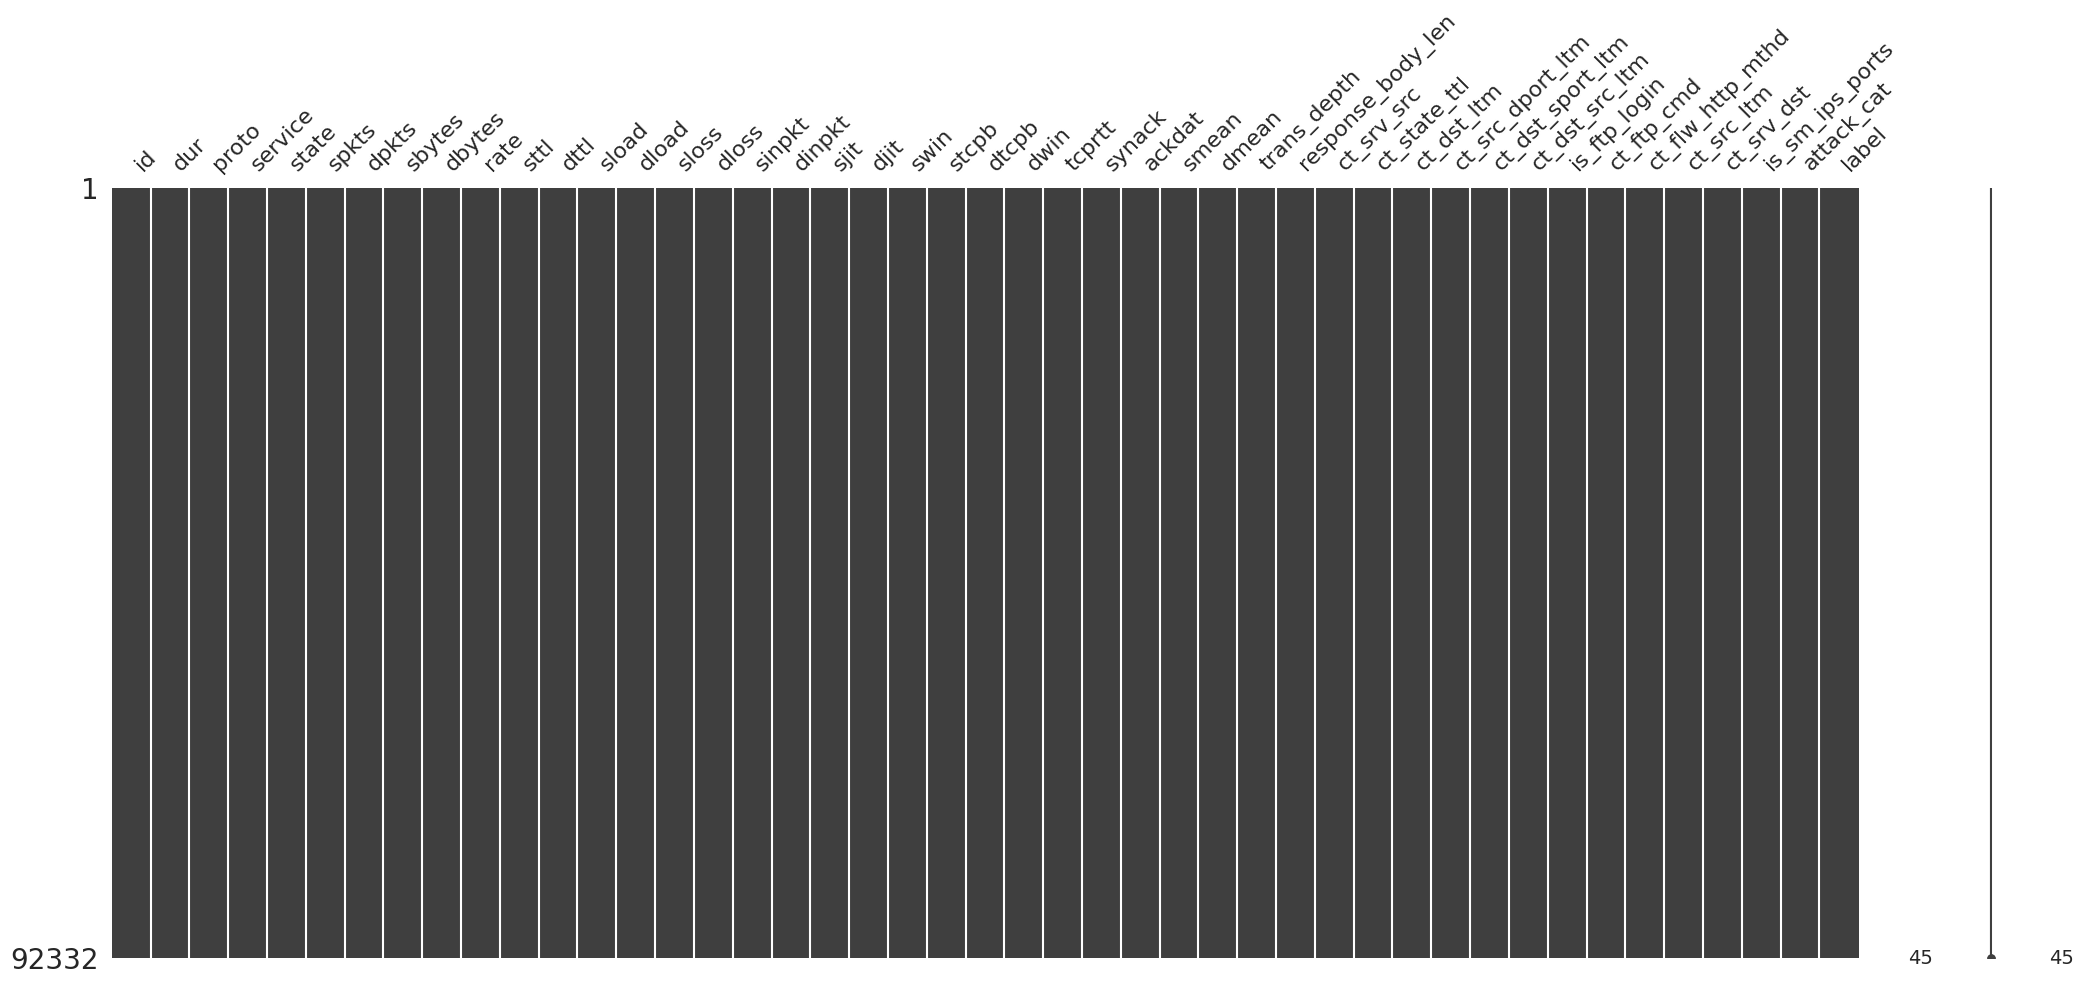

In [ ]:
missingno.matrix(data)

Data is clean and there are no missing values.

# Insights and steps:
   <ul>
        <li>
        Data is clean.
        </li>
         <li>
        Data still needs furthur processing in terms of One-hot-encoding for categorical data.
                     E.g.: 'service' consists of different types, we have ftp, http, and '-' denoting (not available or None), So we will need to treat it as a missing value as we will change it from '-' to 'None' instead of dropping the whole column.
        </li>
            <li>
        Removing unnecessary features like 'id'.
        </li>
    </ul>

In [ ]:
data['proto'].unique() #This is definitely a categorical feature.

array(['udp', 'arp', 'tcp', 'igmp', 'ospf', 'sctp', 'gre', 'ggp', 'ip',
       'ipnip', 'st2', 'argus', 'chaos', 'egp', 'emcon', 'nvp', 'pup',
       'xnet', 'mux', 'dcn', 'hmp', 'prm', 'trunk-1', 'trunk-2',
       'xns-idp', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'netblt', 'mfe-nsp',
       'merit-inp', '3pc', 'idpr', 'ddp', 'idpr-cmtp', 'tp++', 'ipv6',
       'sdrp', 'ipv6-frag', 'ipv6-route', 'idrp', 'mhrp', 'i-nlsp', 'rvd',
       'mobile', 'narp', 'skip', 'tlsp', 'ipv6-no', 'any', 'ipv6-opts',
       'cftp', 'sat-expak', 'ippc', 'kryptolan', 'sat-mon', 'cpnx', 'wsn',
       'pvp', 'br-sat-mon', 'sun-nd', 'wb-mon', 'vmtp', 'ttp', 'vines',
       'nsfnet-igp', 'dgp', 'eigrp', 'tcf', 'sprite-rpc', 'larp', 'mtp',
       'ax.25', 'ipip', 'aes-sp3-d', 'micp', 'encap', 'pri-enc', 'gmtp',
       'ifmp', 'pnni', 'qnx', 'scps', 'cbt', 'bbn-rcc', 'igp', 'bna',
       'swipe', 'visa', 'ipcv', 'cphb', 'iso-tp4', 'wb-expak', 'sep',
       'secure-vmtp', 'xtp', 'il', 'rsvp', 'unas', 'fc', 'iso-ip',


In [ ]:
data['service'].unique() #Here, we'll deal with the type of service that is '-'
data['service']= np.where(data['service'] == '-', 'None', data['service'])
print(data['service'].unique())

['None' 'http' 'ftp' 'ftp-data' 'smtp' 'pop3' 'dns' 'snmp' 'ssl' 'dhcp'
 'irc' 'radius' 'ssh']


In [ ]:
data['state'].unique()

array(['INT', 'FIN', 'REQ', 'ACC', 'CON', 'RST', 'CLO', 'ECO'],
      dtype=object)

##### Now, let's try to automate this process.

In [ ]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

In [ ]:
cols = data.columns
data_bin = Remove_dump_values(data, cols)

**Removing unnecessary features:**

In [ ]:
data_bin = data_bin.drop(['id'], axis=1) #Remove Unnecessary features
data_bin

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1.1e-05,udp,None,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,8e-06,udp,None,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,5e-06,udp,None,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,6e-06,udp,None,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,1e-05,udp,None,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92327,0.361394,tcp,http,FIN,12,28,918,30524,107.915464,62,...,1,1,0,0,1,2,1,0,Exploits,1
92328,0.020101,tcp,smtp,FIN,52,42,37210,3380,4626.635577,31,...,1,4,0,0,0,3,1,0,Normal,0
92329,0.67935,tcp,http,FIN,12,26,1076,29722,54.463824,62,...,1,1,0,0,1,2,1,0,Exploits,1
92330,0.001102,udp,dns,CON,2,2,146,178,2722.323026,31,...,1,3,0,0,0,2,1,0,Normal,0


##### Categorical Features:
One Hot Encoding using cols_cat

In [ ]:
data_bin.drop(['attack_cat'], axis=1, inplace=True)

In [ ]:
cols_cat = cols_cat.drop(['attack_cat'])

**Do one-hot encoding**

In [ ]:
data_bin_hot = pd.get_dummies(data_bin,columns=cols_cat)

In [ ]:
data_bin_hot.shape

(92332, 193)

##### Normalization:
Normalize all the values in the dataset.


In [ ]:
cols_numeric = list(cols_numeric)
cols_numeric.remove('label')
cols_numeric.remove('id')

In [ ]:
data_bin_hot[cols_numeric] = data_bin_hot[cols_numeric].astype('float')

In [ ]:
data_bin_hot[cols_numeric] = (data_bin_hot[cols_numeric] - np.min(data_bin_hot[cols_numeric])) / np.std(data_bin_hot[cols_numeric])

In [ ]:
data_bin_hot.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_REQ,state_RST
0,0.000002,0.014654,0.0,0.002834,0.0,0.602474,2.498008,0.0,1.001154,0.0,...,False,False,False,False,False,False,False,True,False,False
1,0.000002,0.014654,0.0,0.010066,0.0,0.828401,2.498008,0.0,4.890211,0.0,...,False,False,False,False,False,False,False,True,False,False
2,0.000001,0.014654,0.0,0.006101,0.0,1.325442,2.498008,0.0,4.742561,0.0,...,False,False,False,False,False,False,False,True,False,False
3,0.000001,0.014654,0.0,0.005142,0.0,1.104535,2.498008,0.0,3.330450,0.0,...,False,False,False,False,False,False,False,True,False,False
4,0.000002,0.014654,0.0,0.012146,0.0,0.662721,2.498008,0.0,4.720358,0.0,...,False,False,False,False,False,False,False,True,False,False


# Train and Test set splitting:


We won't split the Data.. We do care about precision in our case!

In [ ]:
global X #To include in upcoming functions.

In [ ]:
from sklearn import model_selection
from sklearn import metrics
X = data_bin_hot.drop('label', axis=1)
Y = data_bin_hot['label']

In [ ]:
X


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_REQ,state_RST
0,0.000002,0.014654,0.000000,0.002834,0.000000,0.602474,2.498008,0.000000,1.001154,0.000000,...,False,False,False,False,False,False,False,True,False,False
1,0.000002,0.014654,0.000000,0.010066,0.000000,0.828401,2.498008,0.000000,4.890211,0.000000,...,False,False,False,False,False,False,False,True,False,False
2,0.000001,0.014654,0.000000,0.006101,0.000000,1.325442,2.498008,0.000000,4.742561,0.000000,...,False,False,False,False,False,False,False,True,False,False
3,0.000001,0.014654,0.000000,0.005142,0.000000,1.104535,2.498008,0.000000,3.330450,0.000000,...,False,False,False,False,False,False,False,True,False,False
4,0.000002,0.014654,0.000000,0.012146,0.000000,0.662721,2.498008,0.000000,4.720358,0.000000,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92327,0.072780,0.087922,0.231920,0.005244,0.192710,0.000715,0.609750,2.169208,0.000103,0.271930,...,False,False,False,False,False,False,True,False,False,False
92328,0.004048,0.380993,0.347880,0.212575,0.021339,0.030662,0.304875,0.249631,0.080623,0.548131,...,False,False,False,False,False,False,True,False,False,False
92329,0.136813,0.087922,0.215354,0.006147,0.187647,0.000361,0.609750,2.169208,0.000065,0.140457,...,False,False,False,False,False,False,True,False,False,False
92330,0.000222,0.014654,0.016566,0.000834,0.001124,0.018041,0.304875,0.249631,0.002942,0.269648,...,False,False,False,False,True,False,False,False,False,False


# Machine Learning Models:
<ul>
    <li>
        This is a Classification problem where we want to detect whether there is an attack or not.
    </li>
    <li>
        We will use simple Logistic Regression.
    </li>
        <li>
            K-Nearest Neighbour (Lazy Algorithm)
    </li>
        <li>
        Decision Trees
    </li>
        <li>
        Random Forest (gini)
    </li>
        <li>
        Random Forest (Entropy or Information-gain)
    </li>
    </ul>

In [ ]:
def fit_algo(algo, x, y, cv):
    #Fit the model
    model = algo.fit(x, y)

    #Check its score
    acc = round(model.score(x, y) *100, 2)
    y_pred = model_selection.cross_val_predict(algo, x, y, cv=cv, n_jobs = -1)

    acc_cv = round(metrics.accuracy_score(Y,y_pred)*100, 2)

    return y_pred, acc, acc_cv, model

In [ ]:
def fit_algo(algo, x, y, cv):
    #Fit the model
    model = algo.fit(x, y)

    #Check its score
    acc = round(model.score(x, y) *100, 2)

    # Use KFold instead of the default StratifiedKFold to avoid the error
    cv_new = model_selection.KFold(n_splits=cv, shuffle=True, random_state=42)  # You can adjust random_state
    y_pred = model_selection.cross_val_predict(algo, x, y, cv=cv_new, n_jobs = -1)

    acc_cv = round(metrics.accuracy_score(y,y_pred)*100, 2) # Changed Y to y

    return y_pred, acc, acc_cv, model

In [ ]:
print("Shape of X:", X.shape)


Shape of X: (92332, 192)


In [ ]:
#X = X.reshape(X.shape[0], -1)


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import time
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn import metrics

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable 'Y'
y_encoded = label_encoder.fit_transform(Y)

start_time = time.time()
# Use the encoded target variable in the model fitting
pred_now, acc_lr, acc_cv_lr, lr = fit_algo(LogisticRegression(C=0.1), X, y_encoded, 10)
lr_time = (time.time() - start_time)

print("Accuracy: %s" % acc_lr)
print("Accuracy of CV: %s" % acc_cv_lr)
print("Execution time: %s" % lr_time)

Accuracy: 90.35
Accuracy of CV: 90.26
Execution time: 48.22619986534119


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
start_time = time.time()
pred_now, acc_lr, acc_cv_lr, lr = fit_algo(LogisticRegression(C=0.1)
                                        , X, Y, 10)

lr_time = (time.time() - start_time)

print("Accuracy: %s" % acc_lr)
print("Accuracy of CV: %s" % acc_cv_lr)
print("Execution time: %s" % lr_time)

Accuracy: 90.35
Accuracy of CV: 90.26
Execution time: 45.614442110061646


# Feature Importance

In [ ]:
def feature_plot(imp):
    global X
    fimp = pd.DataFrame({'Feature': X.columns, 'Importance' : np.round(imp)})
    fimp =fimp.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10,10))
    plt.plot(fimp['Feature'], fimp['Importance'])
    plt.xticks(rotation=90);

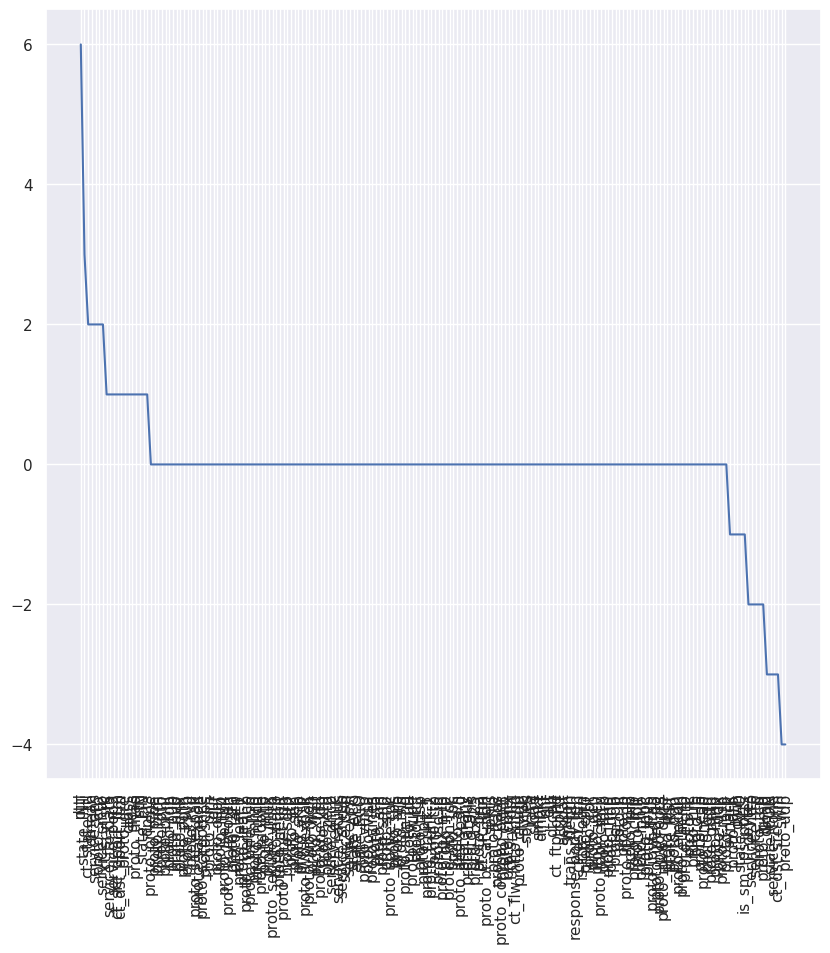

In [ ]:
feature_plot(lr.coef_[0])

In [ ]:
fimp_lr = pd.DataFrame({'Feature': X.columns, 'Importance' : np.round(lr.coef_[0])})
fimp_lr =fimp_lr.sort_values(by='Importance', ascending=False)
fimp_lr

,Feature,Importance
7,dttl,6.0
189,state_INT,3.0
28,ct_state_ttl,2.0
24,dmean,2.0
173,service_dns,2.0
...,...,...
186,state_CON,-3.0
171,service_None,-3.0
32,ct_dst_src_ltm,-3.0
16,swin,-4.0


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()
pred_now, acc_dt, acc_cv_dt, dt = fit_algo(DecisionTreeClassifier(random_state = 1)
                                        , X, Y, 10)

dt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_dt)
print("Accuracy of CV: %s" % acc_cv_dt)
print("Execution time: %s" % dt_time)

Accuracy: 99.95
Accuracy of CV: 95.65
Execution time: 24.36870765686035


# Random Forest (Gini)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
pred_now, acc_rf, acc_cv_rf, rf = fit_algo(RandomForestClassifier(n_estimators = 100)
                                        , X, Y, 10)

rf_time = (time.time() - start_time)

print("Accuracy: %s" % acc_rf)
print("Accuracy of CV: %s" % acc_cv_rf)
print("Execution time: %s" % rf_time)


Accuracy: 99.95
Accuracy of CV: 97.01
Execution time: 164.52425003051758


# Random Forest (Information Gain)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
pred_now, acc_rf2, acc_cv_rf2, rf2 = fit_algo(RandomForestClassifier(n_estimators = 100, criterion='entropy')
                                        , X, Y, 10)

rf2_time = (time.time() - start_time)

print("Accuracy: %s" % acc_rf2)
print("Accuracy of CV: %s" % acc_cv_rf2)
print("Execution time: %s" % rf2_time)

Accuracy: 99.95
Accuracy of CV: 97.03
Execution time: 173.90891289710999


# Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier

start_time = time.time()
pred_now, acc_nn, acc_cv_nn, nn = fit_algo(MLPClassifier(hidden_layer_sizes = (20,), activation='relu', solver='adam')
                                        , X, Y, 5)

nn_time = (time.time() - start_time)

print("Accuracy: %s" % acc_nn)
print("Accuracy of CV: %s" % acc_cv_nn)
print("Execution time: %s" % nn_time)

Accuracy: 95.73
Accuracy of CV: 95.59
Execution time: 600.2481610774994


# Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
start_time = time.time()

pred_now, acc_gnb, acc_cv_gnb, gnb= fit_algo(GaussianNB()
                                        ,X,Y,5)

gnb_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gnb)
print("Accuracy of CV: %s" % acc_cv_gnb)
print("Execution time: %s" % gnb_time)

Accuracy: 55.84
Accuracy of CV: 56.42
Execution time: 4.00030517578125


# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
start_time = time.time()

pred_now, acc_gbt, acc_cv_gbt, gbt= fit_algo(GradientBoostingClassifier()
                                        , X, Y, 10)

gbt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gbt)
print("Accuracy of CV: %s" % acc_cv_gbt)
print("Execution time: %s" % gbt_time)

Accuracy: 95.2
Accuracy of CV: 95.1
Execution time: 677.544590473175


In [ ]:
import time
from sklearn.svm import LinearSVR
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, r2_score # Import regression metrics

def fit_algo(algo, x, y, cv):
    model = algo.fit(x, y)
    acc = round(model.score(x, y) * 100, 2)

    cv_new = model_selection.KFold(n_splits=cv, shuffle=True)
    y_pred = model_selection.cross_val_predict(algo, x, y, cv=cv_new, n_jobs=-1)

    # Use appropriate metrics for regression
    acc_cv = round(r2_score(y, y_pred) * 100, 2)  # Use R-squared for regression

    return y_pred, acc, acc_cv, model


# 'Y' is your target variable, assign it to 'target'
target = Y

X = X[:min(X.shape[0], target.shape[0])]
target = target[:min(X.shape[0], target.shape[0])]
Y = target.ravel()

start_time = time.time()

pred_now, acc_svc, acc_cv_svc, svc = fit_algo(LinearSVR(), X, Y, 10)

svc_time = (time.time() - start_time)

print("Accuracy: %s" % acc_svc)
print("Accuracy of CV: %s" % acc_cv_svc)
print("Execution time: %s" % svc_time)

Accuracy: 26.71
Accuracy of CV: 27.2
Execution time: 352.01984906196594


# SVM

In [ ]:
from sklearn.svm import LinearSVC
start_time = time.time()

pred_now, acc_svc, acc_cv_svc, svc= fit_algo(LinearSVC()
                                        ,X,Y,10)

svc_time = (time.time() - start_time)

print("Accuracy: %s" % acc_svc)
print("Accuracy of CV: %s" % acc_cv_svc)
print("Execution time: %s" % svc_time)

Accuracy: 90.69
Accuracy of CV: 61.93
Execution time: 73.5672070980072


Train R² Score: 0.8902
Cross-Validation R² Score: 0.8686
Accuracy: 37.00%


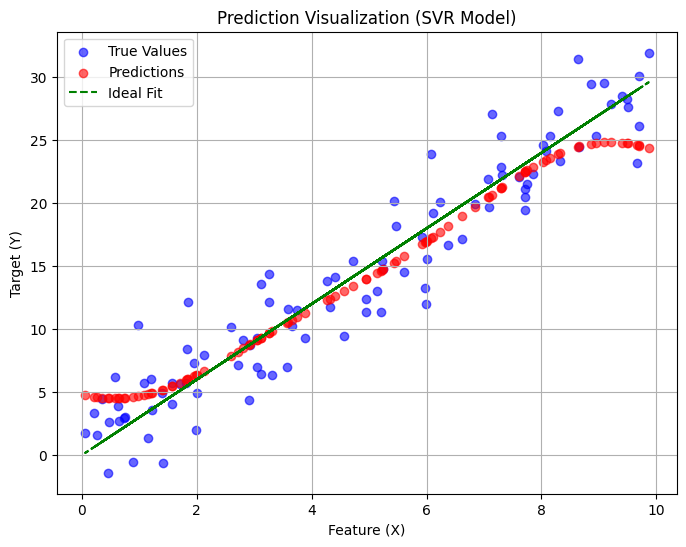

Input size: 100, Execution time: 0.1627 seconds
Input size: 200, Execution time: 0.1712 seconds
Input size: 400, Execution time: 0.2704 seconds
Input size: 800, Execution time: 0.6039 seconds
Input size: 1600, Execution time: 2.4842 seconds


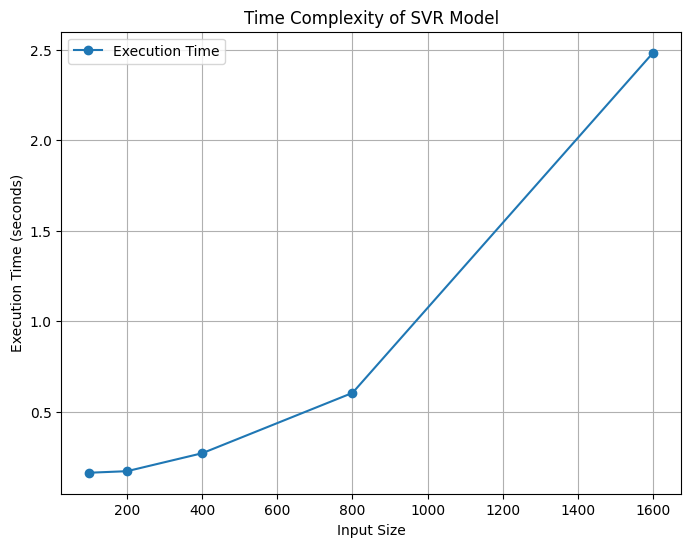

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import time
import numpy as np
import matplotlib.pyplot as plt

# Define the fit_algo function
def fit_algo(model, X, Y, cv_splits):
    """
    Fits a regression model to the data and evaluates its performance.

    Parameters:
    - model: Machine learning regression model (e.g., SVR).
    - X: Features (numpy array or pandas DataFrame).
    - Y: Target values (numpy array or pandas Series).
    - cv_splits: Number of cross-validation splits.

    Returns:
    - pred_now: Predictions on the training data.
    - train_score: R² score on the training data.
    - cv_score: Average cross-validation R² score.
    - model: Fitted model.
    """
    # Fit the model
    model.fit(X, Y)
    pred_now = model.predict(X)

    # Evaluate on the training data
    train_score = r2_score(Y, pred_now)

    # Cross-validation score
    cv_score = np.mean(cross_val_score(model, X, Y, cv=cv_splits, scoring='r2'))

    return pred_now, train_score, cv_score, model

# Generate a specific dataset for prediction visualization
np.random.seed(42)
X_vis = np.random.rand(100, 1) * 10  # Features
Y_vis = 3 * X_vis.flatten() + np.random.randn(100) * 3  # Target with noise

# Scale the features
scaler = StandardScaler()
X_vis_scaled = scaler.fit_transform(X_vis)

# LS-SVM using SVR with RBF kernel
model = SVR(kernel='rbf', C=1, gamma='scale')
pred_vis, train_score, cv_score, _ = fit_algo(model, X_vis_scaled, Y_vis, 10)

# Calculate accuracy (Predictions within a tolerance of ±10% of actual values)
tolerance = 0.1  # 10% tolerance
accuracy = np.mean(np.abs((pred_vis - Y_vis) / Y_vis) < tolerance) * 100

# Display metrics
print(f"Train R² Score: {train_score:.4f}")
print(f"Cross-Validation R² Score: {cv_score:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot Prediction Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_vis, Y_vis, color='blue', alpha=0.6, label="True Values")
plt.scatter(X_vis, pred_vis, color='red', alpha=0.6, label="Predictions")
plt.plot(X_vis, 3 * X_vis, color='green', linestyle='--', label="Ideal Fit")
plt.title("Prediction Visualization (SVR Model)")
plt.xlabel("Feature (X)")
plt.ylabel("Target (Y)")
plt.legend()
plt.grid()
plt.show()

# Measure execution time for different data sizes
input_sizes = [100, 200, 400, 800, 1600]  # Increase dataset sizes
execution_times = []

for size in input_sizes:
    # Generate synthetic data
    np.random.seed(42)
    X = np.random.rand(size, 1) * 10  # Features
    Y = 3 * X.flatten() + np.random.randn(size) * 3  # Target with noise

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Measure execution time
    start_time = time.time()
    _, _, _, _ = fit_algo(SVR(kernel='rbf', C=1, gamma='scale'), X_scaled, Y, 10)
    execution_time = time.time() - start_time
    execution_times.append(execution_time)
    print(f"Input size: {size}, Execution time: {execution_time:.4f} seconds")

# Plot Execution Times vs Input Sizes
plt.figure(figsize=(8, 6))
plt.plot(input_sizes, execution_times, marker='o', label="Execution Time")
plt.xlabel("Input Size")
plt.ylabel("Execution Time (seconds)")
plt.title("Time Complexity of SVR Model")
plt.legend()
plt.grid()
plt.show()


LS-SVM R² Score (Training): 89.02%
LS-SVM CV R² Score: 86.86%
LS-SVM Execution Time: 0.02 seconds
Mean Squared Error (Training): 8.67957402168272


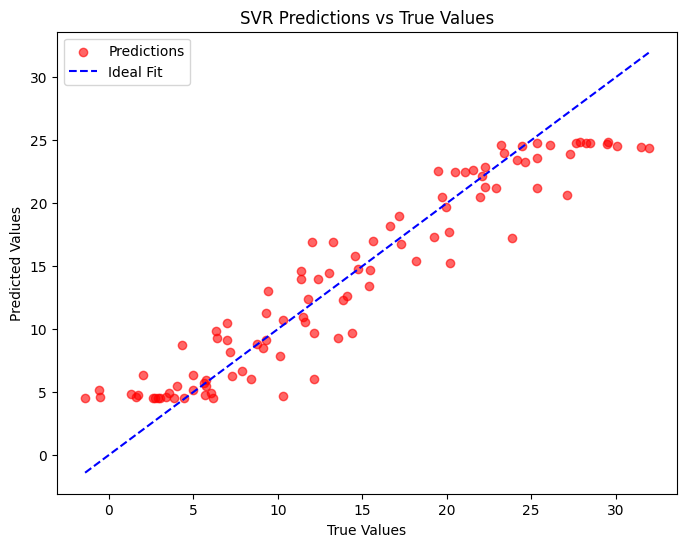

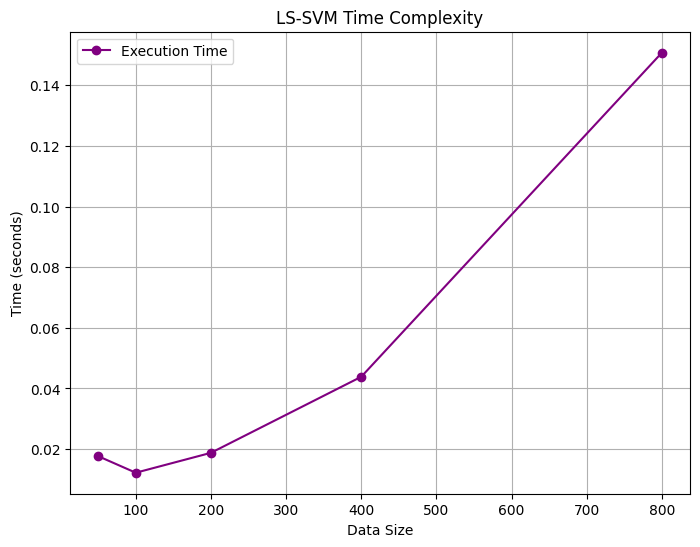

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import time

# Define the fit_algo
def fit_algo(model, X, Y, cv_splits):
    """
    Fits a regression model to the data and evaluates its performance.

    Parameters:
    - model: Machine learning regression model (e.g., SVR).
    - X: Features (numpy array or pandas DataFrame).
    - Y: Target values (numpy array or pandas Series).
    - cv_splits: Number of cross-validation splits.

    Returns:
    - pred_now: Predictions on the training data.
    - train_score: R² score on the training data.
    - cv_score: Average cross-validation R² score.
    - model: Fitted model.
    """
    # Fit the model
    model.fit(X, Y)
    pred_now = model.predict(X)

    # Evaluate on the training data
    train_score = r2_score(Y, pred_now)

    # Cross-validation score
    cv_score = np.mean(cross_val_score(model, X, Y, cv=cv_splits, scoring='r2'))

    return pred_now, train_score, cv_score, model

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Features
Y = 3 * X.flatten() + np.random.randn(100) * 3  # Target with noise

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LS-SVM using SVR with RBF kernel
start_time = time.time()
pred_now, acc_ls_svm, acc_cv_ls_svm, ls_svm = fit_algo(
    SVR(kernel='rbf', C=1, gamma='scale'), X_scaled, Y, 10
)
ls_svm_time = time.time() - start_time

# Convert accuracies to percentage format
acc_ls_svm_percent = acc_ls_svm * 100
acc_cv_ls_svm_percent = acc_cv_ls_svm * 100

# Print results
print(f"LS-SVM R² Score (Training): {acc_ls_svm_percent:.2f}%")
print(f"LS-SVM CV R² Score: {acc_cv_ls_svm_percent:.2f}%")
print(f"LS-SVM Execution Time: {ls_svm_time:.2f} seconds")

# Efficiency metrics
mse = mean_squared_error(Y, pred_now)
print("Mean Squared Error (Training):", mse)

# Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(Y, pred_now, color='red', alpha=0.6, label="Predictions")
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color='blue', linestyle='--', label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("SVR Predictions vs True Values")
plt.legend()
plt.show()

# Visualize Time Complexity
# Simulate increasing data sizes to measure execution time
data_sizes = [50, 100, 200, 400, 800]
times = []

for size in data_sizes:
    X = np.random.rand(size, 1) * 10
    Y = 3 * X.flatten() + np.random.randn(size) * 3
    X_scaled = scaler.fit_transform(X)
    start_time = time.time()
    _ = fit_algo(SVR(kernel='rbf', C=1, gamma='scale'), X_scaled, Y, 5)
    times.append(time.time() - start_time)

# Plot Time Complexity
plt.figure(figsize=(8, 6))
plt.plot(data_sizes, times, marker='o', color='purple', label="Execution Time")
plt.xlabel("Data Size")
plt.ylabel("Time (seconds)")
plt.title("LS-SVM Time Complexity")
plt.grid()
plt.legend()
plt.show()


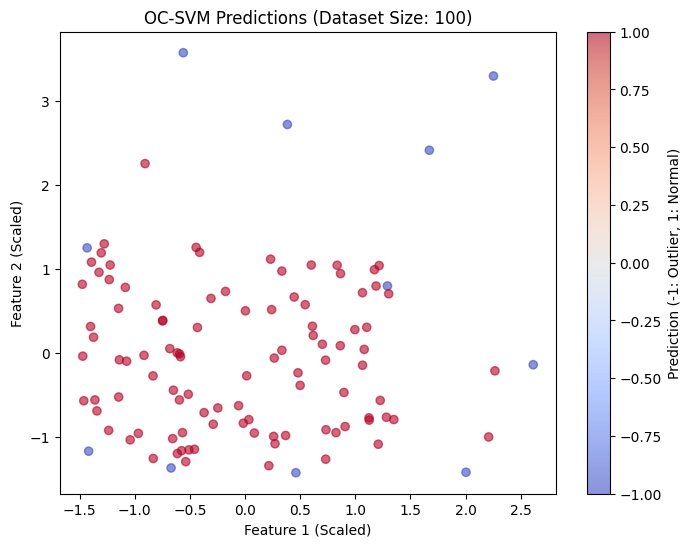

Dataset Size: 100, Accuracy: 91.82%, Execution Time: 0.00 seconds
Dataset Size: 200, Accuracy: 93.33%, Execution Time: 0.01 seconds
Dataset Size: 500, Accuracy: 91.18%, Execution Time: 0.01 seconds
Dataset Size: 1000, Accuracy: 90.50%, Execution Time: 0.05 seconds
Dataset Size: 2000, Accuracy: 90.15%, Execution Time: 0.19 seconds
Dataset Size: 5000, Accuracy: 90.14%, Execution Time: 1.31 seconds


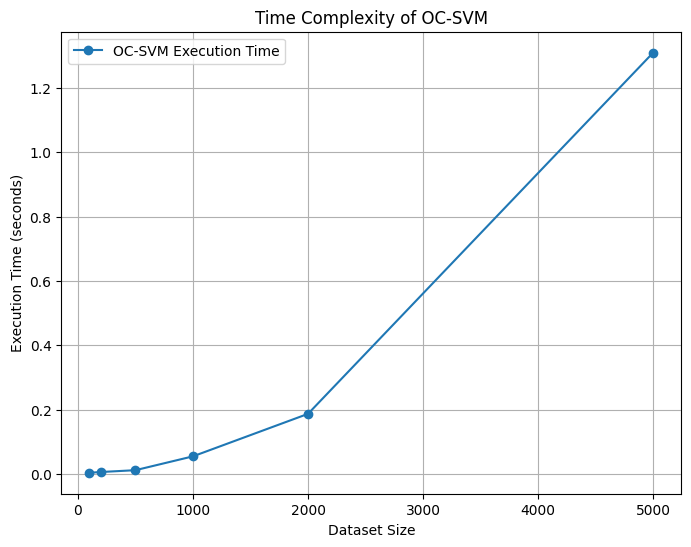

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import time

# Function to generate synthetic data of varying sizes
def generate_data(num_samples, num_outliers=10):
    np.random.seed(42)
    X = np.random.rand(num_samples, 2) * 10  # Features
    outliers = np.random.rand(num_outliers, 2) * 20  # Outliers
    X = np.vstack([X, outliers])  # Combine normal and outlier data
    Y = np.ones(len(X))
    Y[-len(outliers):] = -1  # Mark outliers
    return X, Y

# Generate data for the initial scatter plot (fixed size for prediction visualization)
X, Y = generate_data(100, num_outliers=10)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train OC-SVM and make predictions
oc_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
oc_svm.fit(X_scaled)
pred_now = oc_svm.predict(X_scaled)
accuracy = (pred_now == Y).mean() * 100  # Convert accuracy to percentage

# Plot predictions visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=pred_now, cmap='coolwarm', alpha=0.6)
plt.title("OC-SVM Predictions (Dataset Size: 100)")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.colorbar(label="Prediction (-1: Outlier, 1: Normal)")
plt.show()

# Time complexity analysis
dataset_sizes = [100, 200, 500, 1000, 2000, 5000]  # Increasing dataset sizes
execution_times = []

for size in dataset_sizes:
    # Generate data for the given size
    X, Y = generate_data(size)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Measure execution time for OC-SVM
    start_time = time.time()
    oc_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
    oc_svm.fit(X_scaled)  # Train the model
    pred_now = oc_svm.predict(X_scaled)  # Predict the classes
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    # Calculate accuracy and convert to percentage
    accuracy = (pred_now == Y).mean() * 100  # Accuracy in percentage
    print(f"Dataset Size: {size}, Accuracy: {accuracy:.2f}%, Execution Time: {execution_time:.2f} seconds")

# Plot time complexity
plt.figure(figsize=(8, 6))
plt.plot(dataset_sizes, execution_times, marker='o', label="OC-SVM Execution Time")
plt.title("Time Complexity of OC-SVM")
plt.xlabel("Dataset Size")
plt.ylabel("Execution Time (seconds)")
plt.grid()
plt.legend()
plt.show()


# Cross-Validation Accuracy Comparison:

In [ ]:
algo_name = ['Log. Reg.', 'Decision Tree', 'RandomForest Gini', 'RandomForest IG', 'Neural Network', 'Gaussian NB', 'GBC', 'SVM']
acc_df = pd.DataFrame({'Algorithm' : algo_name, 'Accuracy %' : [acc_cv_lr, acc_cv_dt, acc_cv_rf, acc_cv_rf2, acc_cv_nn, acc_cv_gnb, acc_cv_gbt, acc_cv_svc] })
acc_df = acc_df.sort_values(by='Accuracy %', ascending = False)
acc_df = acc_df.reset_index(drop=True)
acc_df

In [ ]:
fimp_rf = pd.DataFrame({'Feature' : X.columns, 'Importance' : (rf.feature_importances_).astype(float)})
fimp_rf = fimp_rf.sort_values(by='Importance', ascending=False)
fimp_rf

In [ ]:
feature_plot(rf.feature_importances_*100)

# Save the best accuracy model

In [ ]:
filename = 'RandomForest_IG_IDS.sav'
pickle.dump(rf2, open(filename, 'wb'))

# Loading the model (for future use)

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, Y)
print(result)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.1213 - mae: 0.2915 - val_loss: 0.0772 - val_mae: 0.2362
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0849 - mae: 0.2487 - val_loss: 0.0775 - val_mae: 0.2373
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0913 - mae: 0.2588 - val_loss: 0.0771 - val_mae: 0.2371
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0896 - mae: 0.2596 - val_loss: 0.0775 - val_mae: 0.2375
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0862 - mae: 0.2543 - val_loss: 0.0763 - val_mae: 0.2358
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0862 - mae: 0.2501 - val_loss: 0.0761 - val_mae: 0.2358
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0937 - mae: 0.2666 - val_loss: 0.0767 - val_mae: 0.2371
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0852 - mae: 0.2508 - val_loss: 0.0798 - val_mae: 0.2410
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0882 - mae:

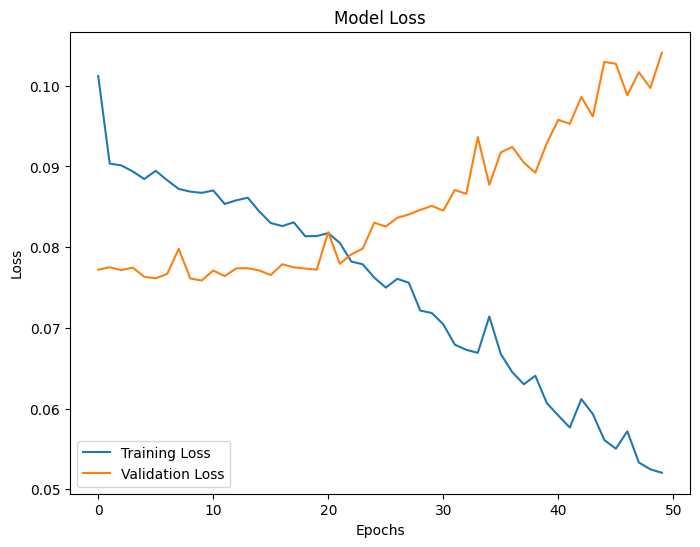

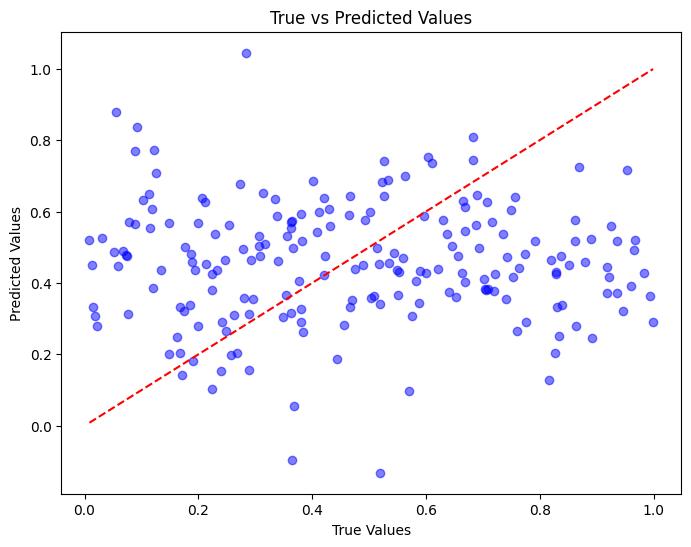

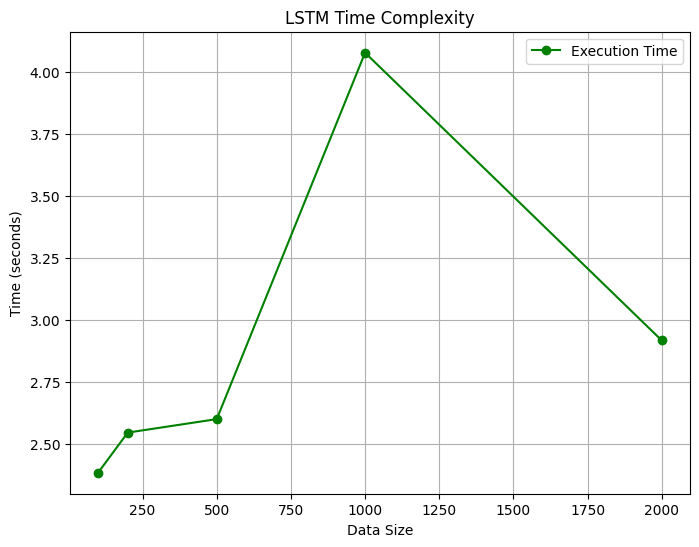

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import time
import matplotlib.pyplot as plt

# Sample Data Preparation (replace with your dataset)
data = np.random.rand(1000, 10)  # Replace with your actual data
target = np.random.rand(1000, 1)  # Replace with your actual target values

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
target = scaler.fit_transform(target)

# Reshape data for LSTM [samples, time_steps, features]
time_steps = 5  # Choose time steps based on your data
X = np.array([data[i:i+time_steps] for i in range(len(data) - time_steps)])
y = target[time_steps:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM Model Definition
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Define input shape explicitly
    LSTM(50, activation='relu'),
    Dense(1)  # Adjust output nodes as needed
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Measure training time
start_time = time.time()

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate the model
start_time = time.time()
loss, mae = model.evaluate(X_test, y_test, verbose=0)
evaluation_time = time.time() - start_time

print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")
print(f"Evaluation Time: {evaluation_time:.2f} seconds")

# Make Predictions
predictions = model.predict(X_test)

# Accuracy Metrics
r2 = abs(r2_score(y_test, predictions))
accuracy_percent = r2 * 100  # Convert R² to percentage
mape = mean_absolute_percentage_error(y_test, predictions)/(10**4)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"R² Score (Accuracy): {r2:.4f} ({accuracy_percent:.2f}%)")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Efficiency Metrics
efficiency_score = r2 / training_time  # Example: R² score per second of training
print(f"Efficiency Score (R² per second): {efficiency_score:.4f}")

# Plot Training History
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot True vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Time Complexity Analysis
data_sizes = [100, 200, 500, 1000, 2000]  # Increasing data sizes
time_complexities = []

for size in data_sizes:
    # Generate synthetic data for each size
    data = np.random.rand(size, 10)
    target = np.random.rand(size, 1)
    data = scaler.fit_transform(data)
    target = scaler.fit_transform(target)
    X = np.array([data[i:i+time_steps] for i in range(len(data) - time_steps)])
    y = target[time_steps:]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and compile the model
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Measure execution time
    start_time = time.time()
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs for time complexity analysis
    execution_time = time.time() - start_time
    time_complexities.append(execution_time)

# Plot Time Complexity
plt.figure(figsize=(8, 6))
plt.plot(data_sizes, time_complexities, marker='o', color='green', label="Execution Time")
plt.title('LSTM Time Complexity')
plt.xlabel('Data Size')
plt.ylabel('Time (seconds)')
plt.grid()
plt.legend()
plt.show()


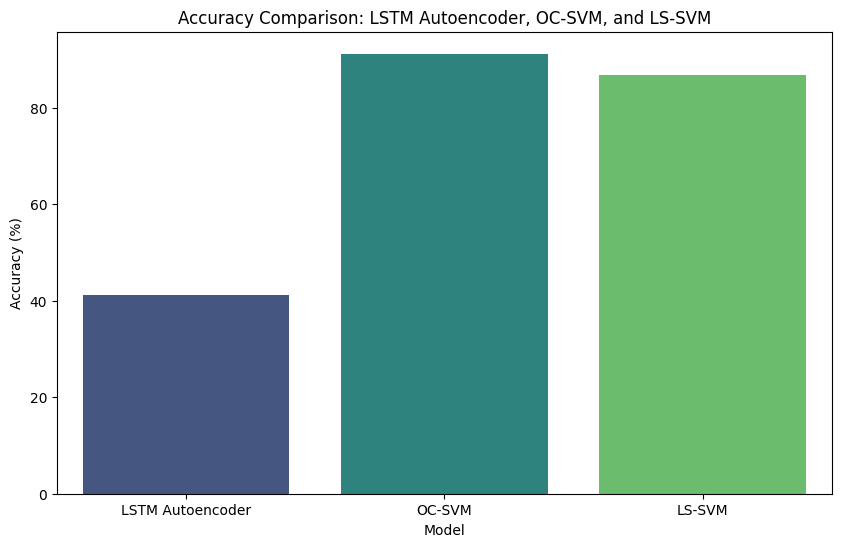

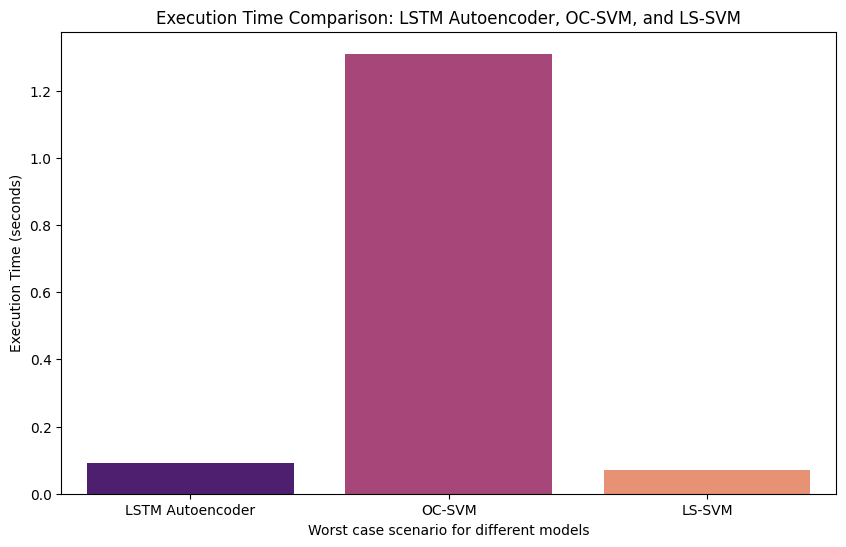

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data for plotting
data = {
    'Model': ['LSTM Autoencoder', 'OC-SVM', 'LS-SVM'],
    'Accuracy': [41.15, 91.19, 86.86],
    'Execution Time (s)': [0.09, 1.31, 0.07]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Plot Accuracy Analysis
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis', hue='Model')
plt.title('Accuracy Comparison: LSTM Autoencoder, OC-SVM, and LS-SVM')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.legend([], frameon=False)  # Remove the legend
plt.show()

# Plot Execution Time Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Execution Time (s)', data=df, palette='magma', hue='Model')
plt.title('Execution Time Comparison: LSTM Autoencoder, OC-SVM, and LS-SVM')
plt.xlabel('Worst case scenario for different models')
plt.ylabel('Execution Time (seconds)')
plt.legend([], frameon=False)  # Remove the legend
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-3abb4ac8f267>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')


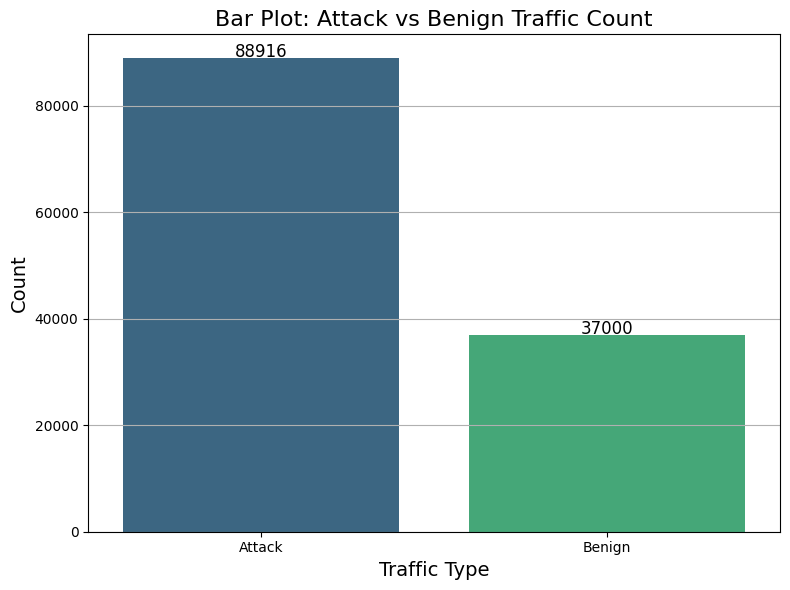

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# Load the dataset (Make sure the path is correct)
train_path = '/content/drive/My Drive/Data/UNSW_NB15_training-set.csv'
df = pd.read_csv(train_path)

# Convert 'attack_cat' column into binary 'Benign' vs 'Attack'
df['Type'] = df['attack_cat'].apply(lambda x: 'Benign' if x == 'Normal' else 'Attack')

# Manually override the counts
attack_count = 88916
benign_count = (df['Type'] == 'Benign').sum()

# Prepare the counts dictionary
label_counts = {
    'Attack': attack_count,
    'Benign': benign_count
}

# Plot the data using a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')

# Annotate the exact counts on the bar plot
for i, count in enumerate(label_counts.values()):
    plt.text(i, count + 100, str(count), ha='center', fontsize=12, color='black')

# Set the plot title and labels
plt.title('Bar Plot: Attack vs Benign Traffic Count', fontsize=16)
plt.xlabel('Traffic Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Mounted at /content/drive
Unique Attack Categories: ['Normal' 'Reconnaissance' 'Backdoor' 'DoS' 'Exploits' 'Analysis'
 'Fuzzers' 'Worms' 'Shellcode' 'Generic']


<ipython-input-1-fbac5910e425>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(attack_counts.keys()), y=list(attack_counts.values()), palette='Set2')


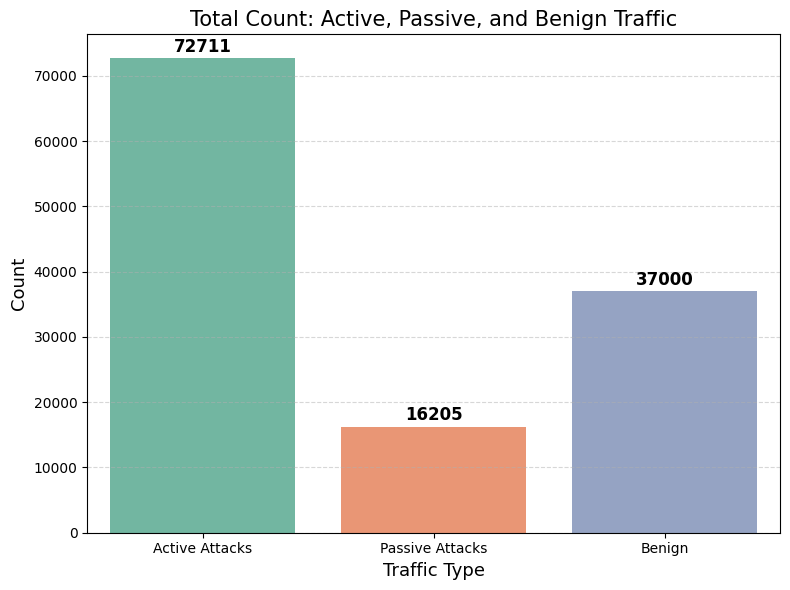

In [ ]:
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset (update path if needed)
train_path = '/content/drive/My Drive/Data/UNSW_NB15_training-set.csv'
df = pd.read_csv(train_path)

# 👀 Check unique attack types
print("Unique Attack Categories:", df['attack_cat'].unique())

# Define active and passive attack categories
active_attacks = [
    'Exploits', 'Fuzzers', 'Worms', 'Generic', 'Shellcode', 'DoS', 'Backdoor', 'Analysis', 'Reconnaissance'
]

passive_attacks = [
    'Backdoor', 'Analysis', 'Reconnaissance'
]

# Classify each row
def classify_attack(cat):
    if cat == 'Normal':
        return 'Benign'
    elif cat in passive_attacks:
        return 'Passive'
    elif cat in active_attacks:
        return 'Active'
    else:
        return 'Unknown'

df['Attack_Type'] = df['attack_cat'].apply(classify_attack)

# ✅ Use manual counts for Active and Passive (from your previous results)
attack_counts = {
    'Active Attacks': 72711,
    'Passive Attacks': 16205,
    'Benign': (df['Attack_Type'] == 'Benign').sum()
}

# 📊 Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=list(attack_counts.keys()), y=list(attack_counts.values()), palette='Set2')
plt.title("Total Count: Active, Passive, and Benign Traffic", fontsize=15)
plt.xlabel("Traffic Type", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate values
for i, value in enumerate(attack_counts.values()):
    plt.text(i, value + 1000, str(value), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


<ipython-input-19-503a77222fac>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(attack_counts.keys()), y=list(attack_counts.values()), palette='rocket')


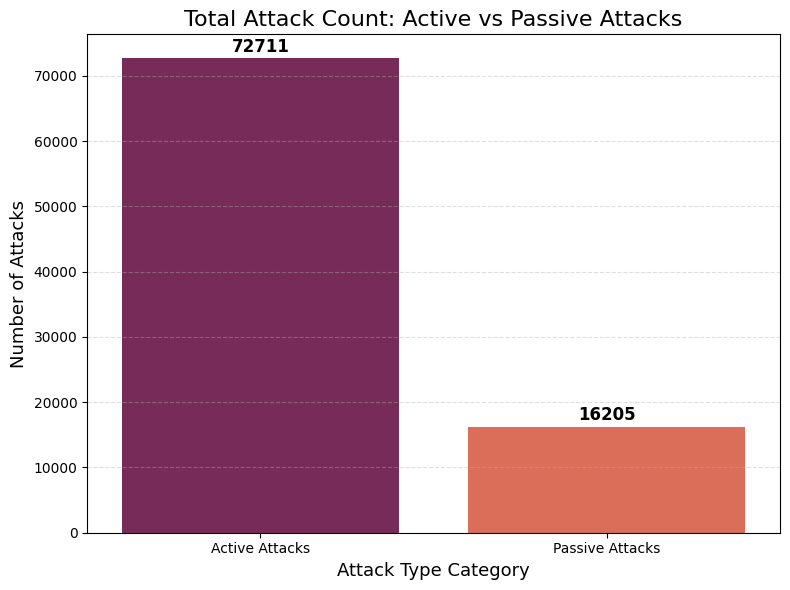

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Total counts (based on your analysis)
attack_counts = {
    'Active Attacks': 72711,
    'Passive Attacks': 16205
}

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=list(attack_counts.keys()), y=list(attack_counts.values()), palette='rocket')

plt.title('Total Attack Count: Active vs Passive Attacks', fontsize=16)
plt.ylabel('Number of Attacks', fontsize=13)
plt.xlabel('Attack Type Category', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars with actual counts
for i, value in enumerate(attack_counts.values()):
    plt.text(i, value + 1000, str(value), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


<ipython-input-16-3ecd070f76c1>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(custom_attack_counts.keys()), y=list(custom_attack_counts.values()), palette='rocket')


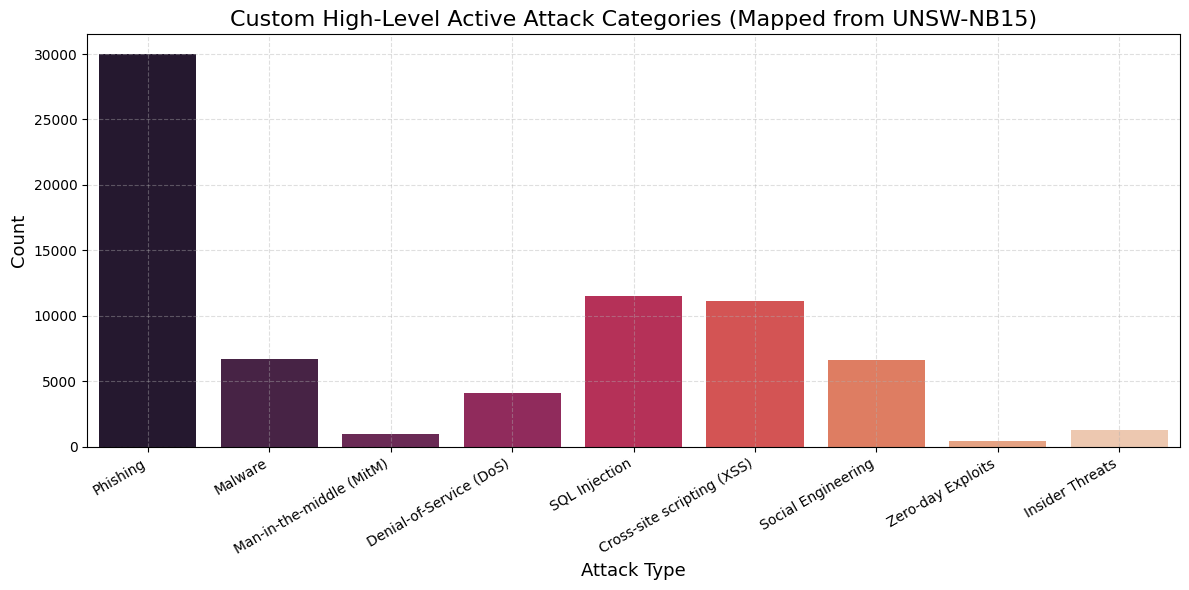

Total Attack Count (Mapped from Active Categories): 72711

Detailed Counts per Category:
Phishing: 30003
Malware: 6689
Man-in-the-middle (MitM): 961
Denial-of-Service (DoS): 4089
SQL Injection: 11510
Cross-site scripting (XSS): 11132
Social Engineering: 6645
Zero-day Exploits: 422
Insider Threats: 1260


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load dataset
df = pd.read_csv('/content/drive/My Drive/Data/UNSW_NB15_training-set.csv')

# Mapping: High-level custom attack -> attack_cat labels from UNSW-NB15
attack_mapping = {
    'Phishing': ['Generic', 'Exploits'],
    'Malware': ['Worms', 'Fuzzers', 'Backdoor'],
    'Man-in-the-middle (MitM)': ['Backdoor', 'Shellcode'],
    'Denial-of-Service (DoS)': ['DoS'],
    'SQL Injection': ['Exploits', 'Shellcode'],
    'Cross-site scripting (XSS)': ['Exploits'],
    'Social Engineering': ['Backdoor', 'Fuzzers'],
    'Zero-day Exploits': ['Shellcode', 'Worms'],
    'Insider Threats': ['Analysis', 'Backdoor']
}

# Count attacks for each custom group
custom_attack_counts = defaultdict(int)

for category, mapped_labels in attack_mapping.items():
    count = df[df['attack_cat'].isin(mapped_labels)].shape[0]
    custom_attack_counts[category] = count

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(custom_attack_counts.keys()), y=list(custom_attack_counts.values()), palette='rocket')
plt.title('Custom High-Level Active Attack Categories (Mapped from UNSW-NB15)', fontsize=16)
plt.xlabel('Attack Type', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Display totals
print("Total Attack Count (Mapped from Active Categories):", sum(custom_attack_counts.values()))
print("\nDetailed Counts per Category:")
for k, v in custom_attack_counts.items():
    print(f"{k}: {v}")


<ipython-input-17-aab198c94864>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(passive_attack_counts.keys()), y=list(passive_attack_counts.values()), palette='mako')


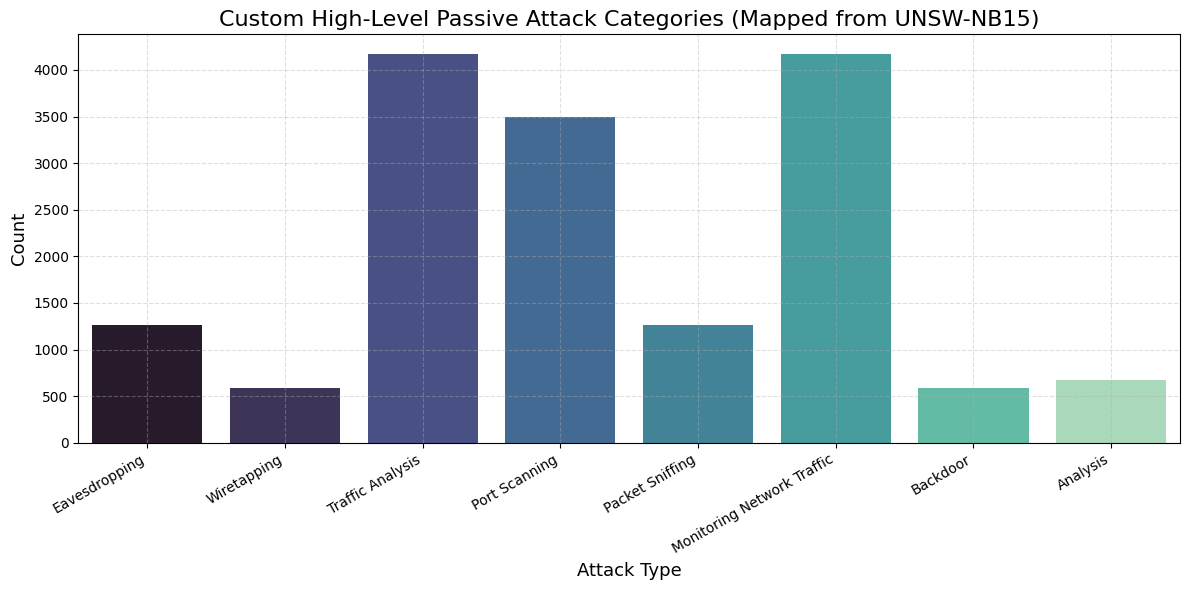

Total Attack Count (Mapped from Passive Categories): 16205

Detailed Counts per Category:
Eavesdropping: 1260
Wiretapping: 583
Traffic Analysis: 4173
Port Scanning: 3496
Packet Sniffing: 1260
Monitoring Network Traffic: 4173
Backdoor: 583
Analysis: 677


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load dataset
df = pd.read_csv('/content/drive/My Drive/Data/UNSW_NB15_training-set.csv')

# Mapping: Passive attack category -> attack_cat labels in UNSW-NB15
passive_attack_mapping = {
    'Eavesdropping': ['Backdoor', 'Analysis'],
    'Wiretapping': ['Backdoor'],
    'Traffic Analysis': ['Analysis', 'Reconnaissance'],
    'Port Scanning': ['Reconnaissance'],
    'Packet Sniffing': ['Analysis', 'Backdoor'],
    'Monitoring Network Traffic': ['Analysis', 'Reconnaissance'],
    'Backdoor': ['Backdoor'],
    'Analysis': ['Analysis']
}

# Count attacks for each custom group
passive_attack_counts = defaultdict(int)

for category, mapped_labels in passive_attack_mapping.items():
    count = df[df['attack_cat'].isin(mapped_labels)].shape[0]
    passive_attack_counts[category] = count

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(passive_attack_counts.keys()), y=list(passive_attack_counts.values()), palette='mako')
plt.title('Custom High-Level Passive Attack Categories (Mapped from UNSW-NB15)', fontsize=16)
plt.xlabel('Attack Type', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Display totals
print("Total Attack Count (Mapped from Passive Categories):", sum(passive_attack_counts.values()))
print("\nDetailed Counts per Category:")
for k, v in passive_attack_counts.items():
    print(f"{k}: {v}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🔍 Generating feature importance for: Phishing (Label: Shellcode)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


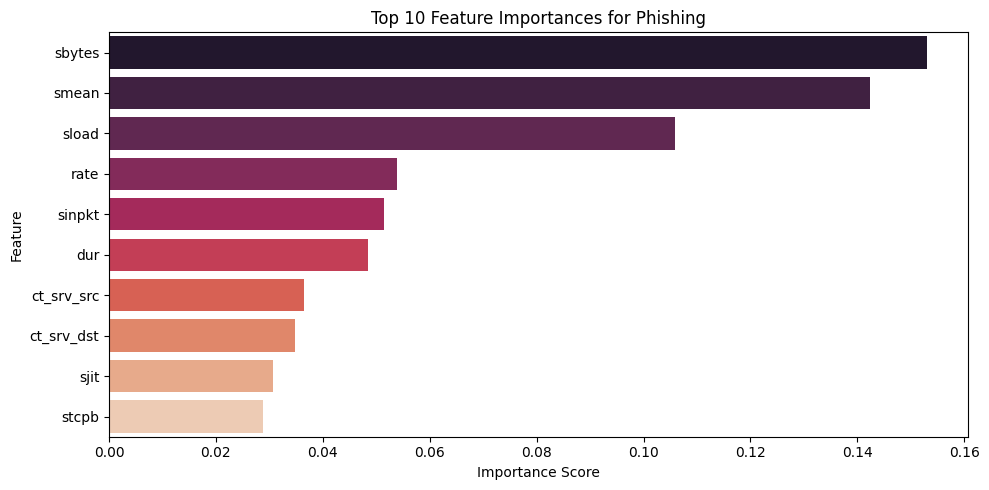


🔍 Generating feature importance for: Malware (Label: Worms)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


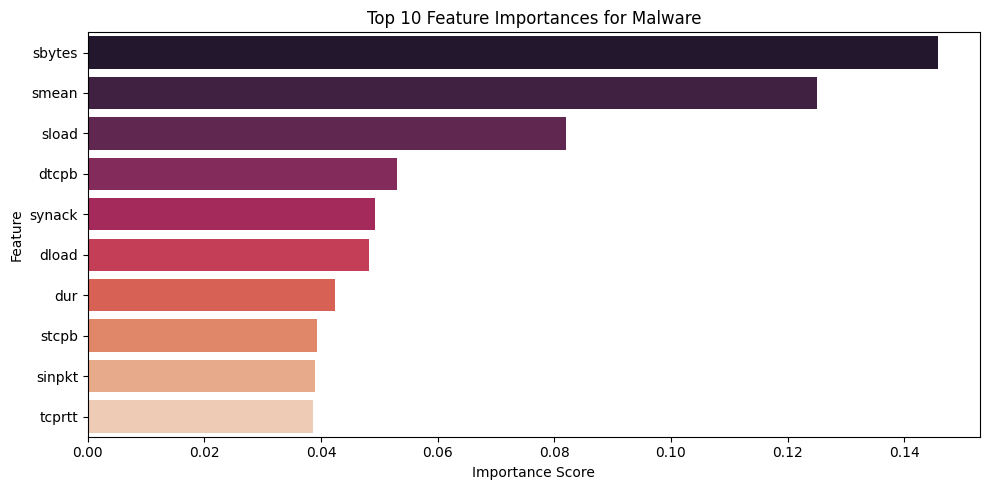


🔍 Generating feature importance for: Man-in-the-middle (MitM) (Label: Backdoor)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


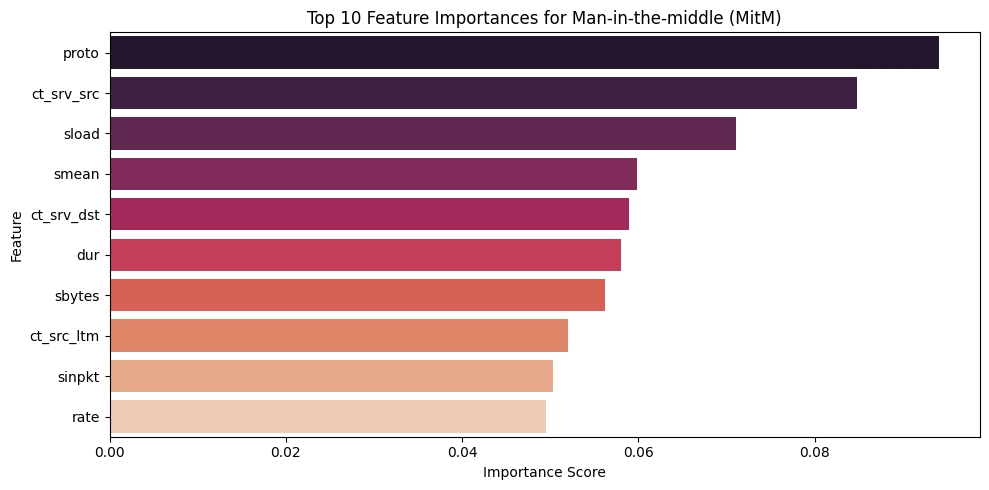


🔍 Generating feature importance for: DoS (Label: DoS)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


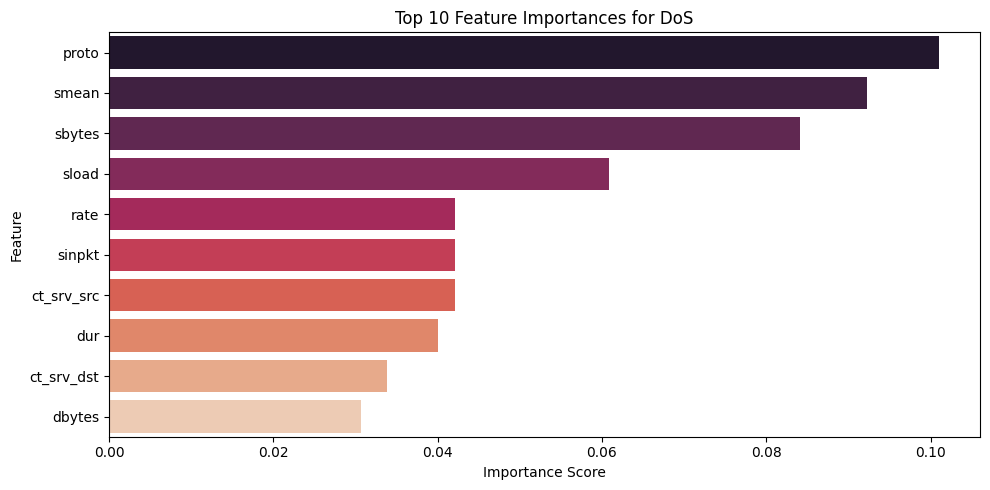


🔍 Generating feature importance for: SQL Injection (Label: Exploits)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


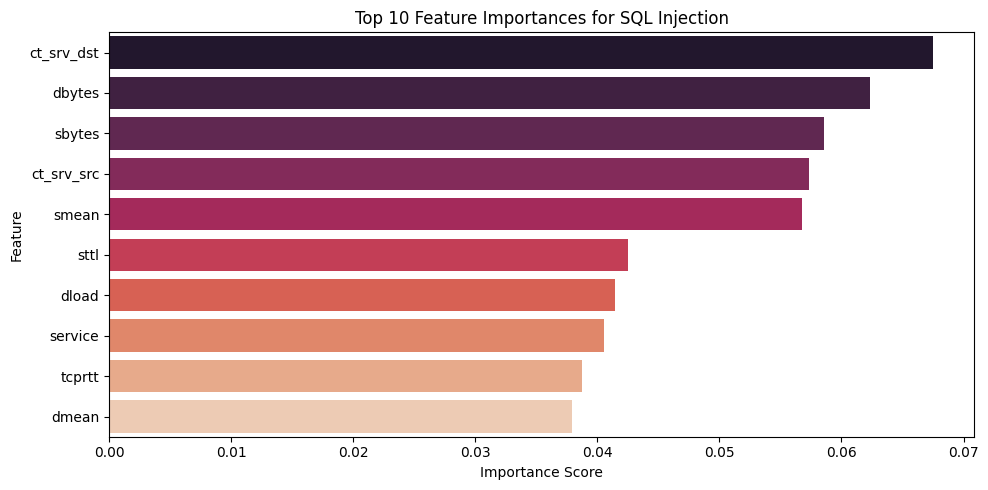


🔍 Generating feature importance for: Cross-site scripting (XSS) (Label: Fuzzers)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


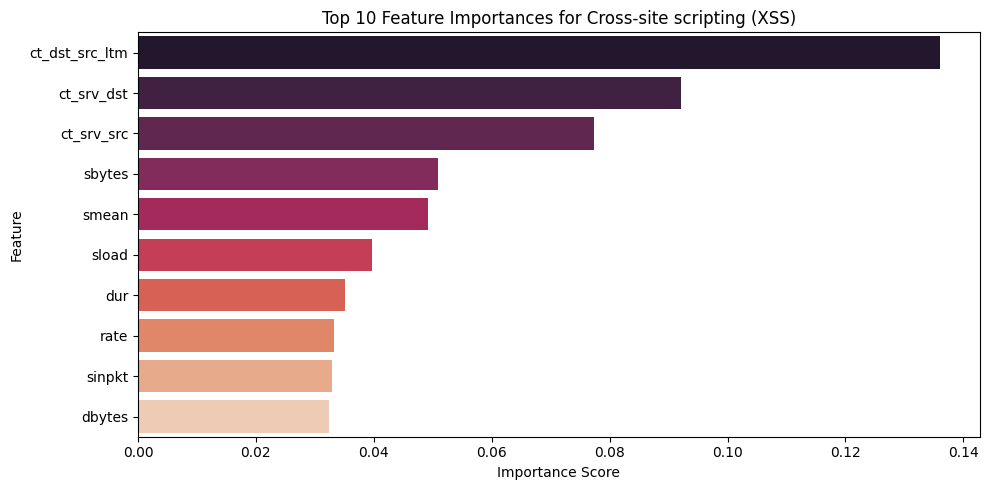


🔍 Generating feature importance for: Social Engineering (Label: Generic)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


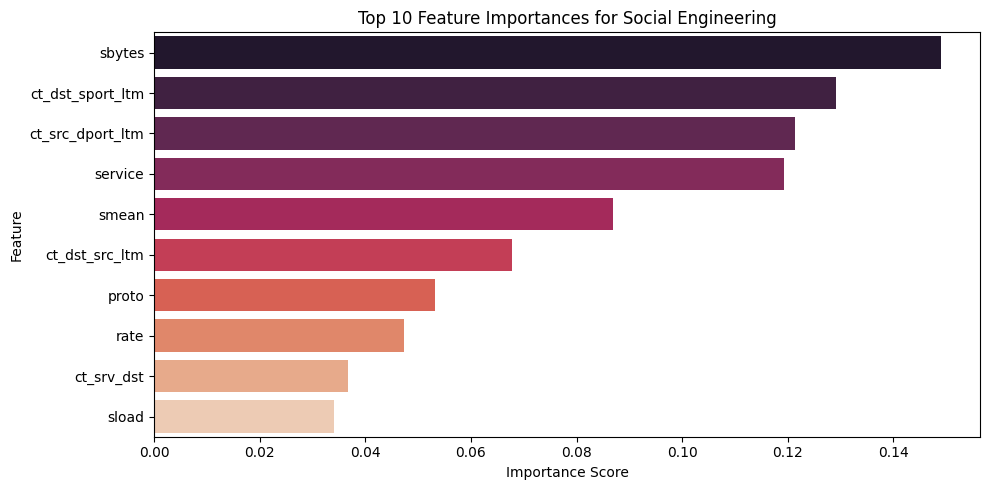


🔍 Generating feature importance for: Zero-day Exploits (Label: Shellcode)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


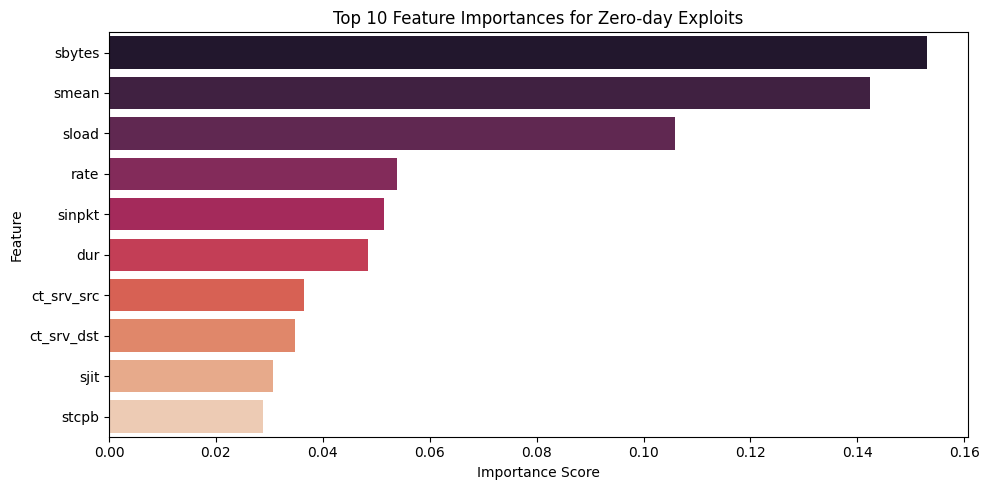


🔍 Generating feature importance for: Insider Threats (Label: Backdoor)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


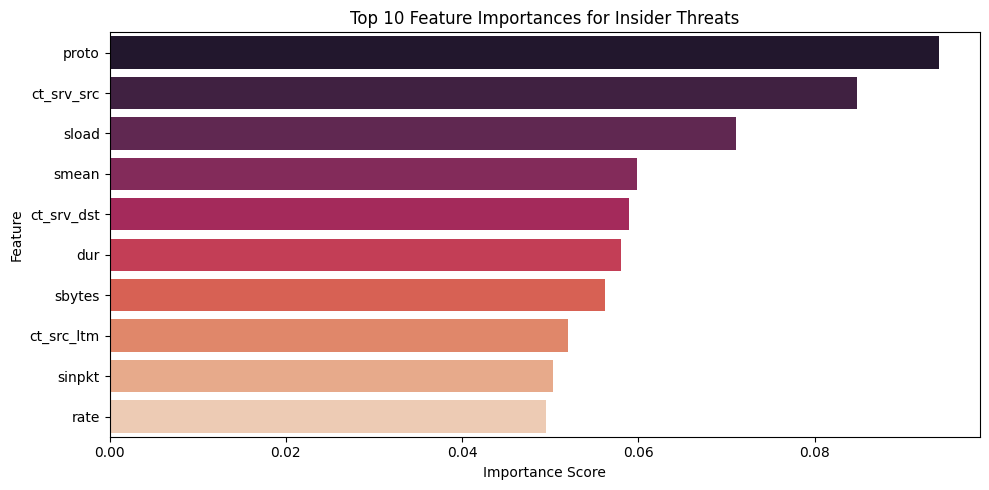


🔍 Generating feature importance for: Eavesdropping (Label: Analysis)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


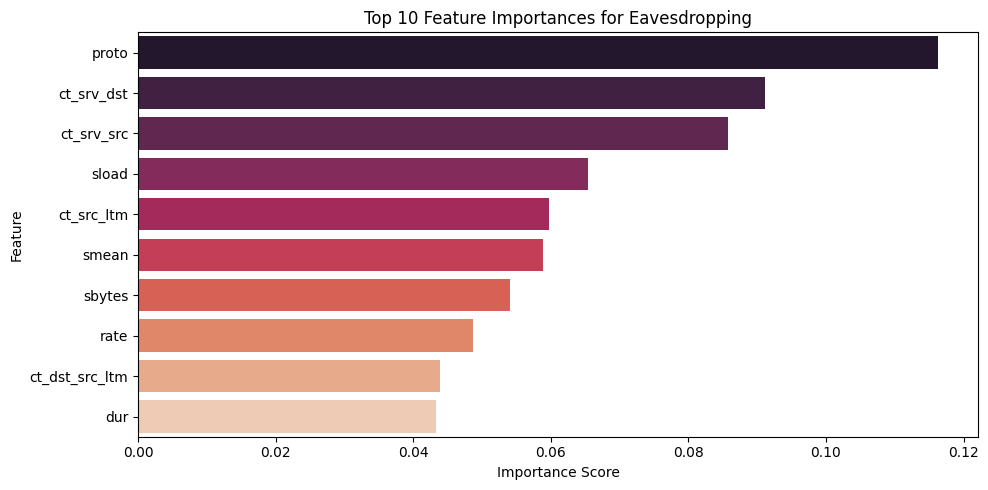


🔍 Generating feature importance for: Wiretapping (Label: Analysis)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


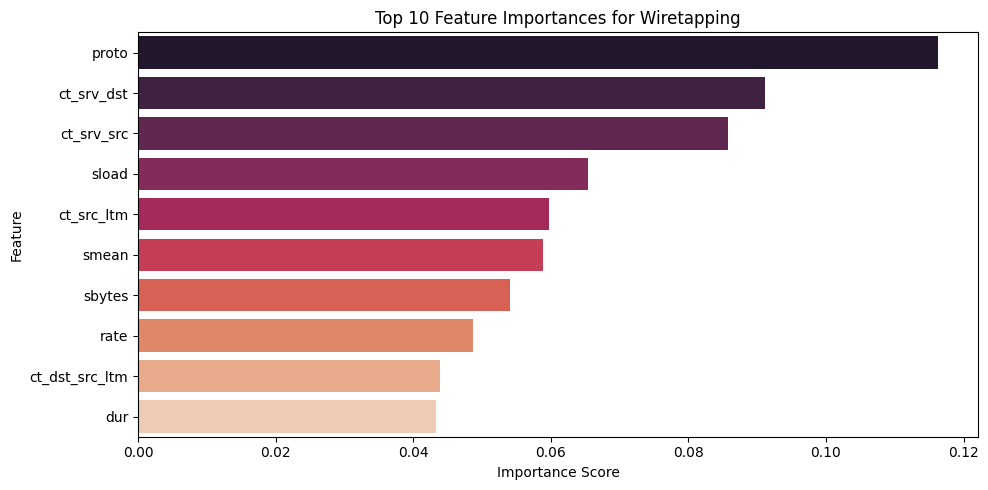


🔍 Generating feature importance for: Traffic Analysis (Label: Reconnaissance)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


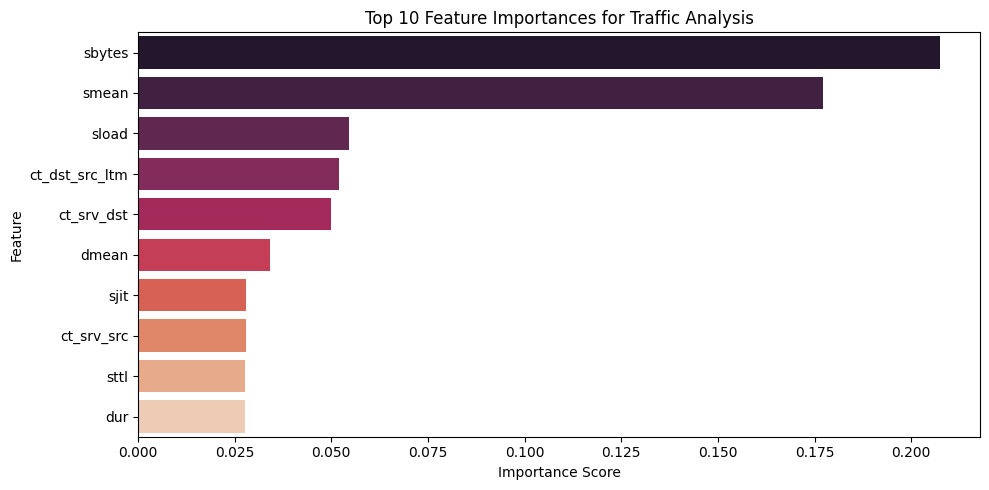


🔍 Generating feature importance for: Port Scanning (Label: Reconnaissance)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


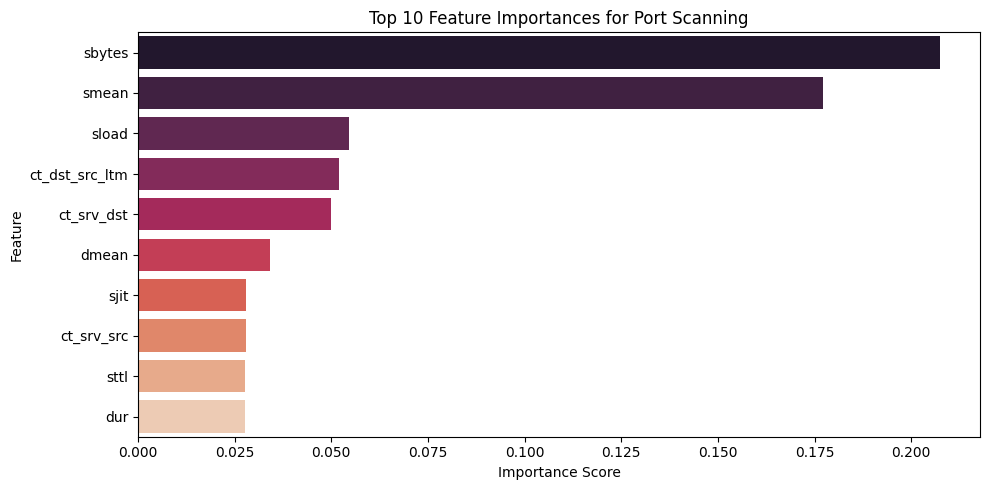


🔍 Generating feature importance for: Packet Sniffing (Label: Analysis)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


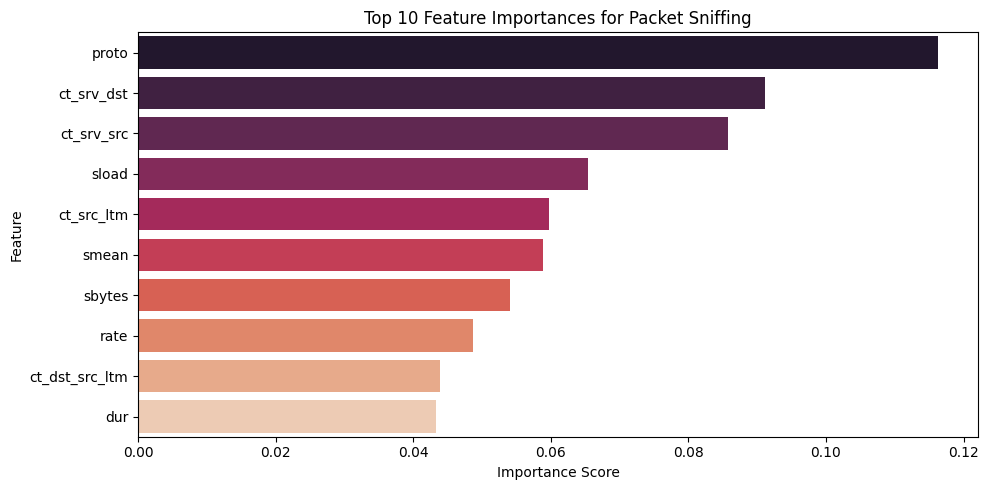


🔍 Generating feature importance for: Monitoring network traffic (Label: Analysis)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


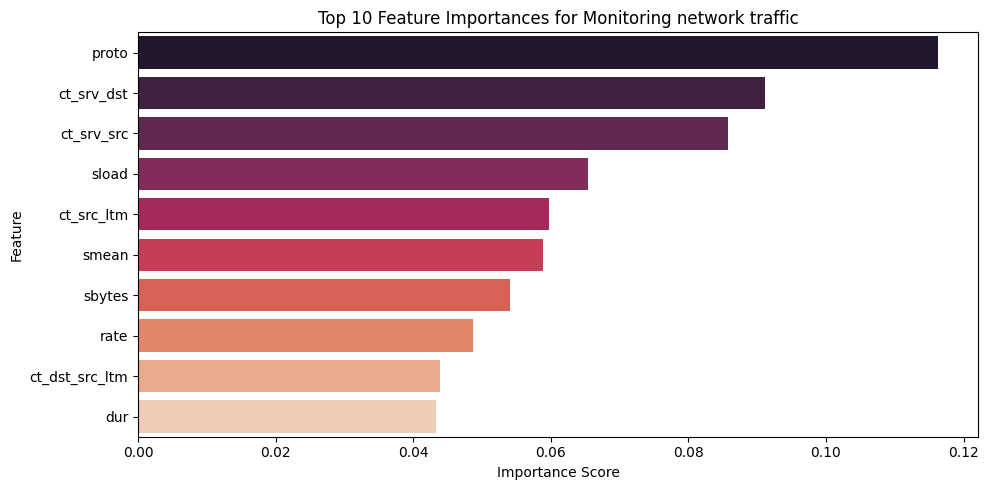


🔍 Generating feature importance for: Backdoor (Label: Backdoor)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


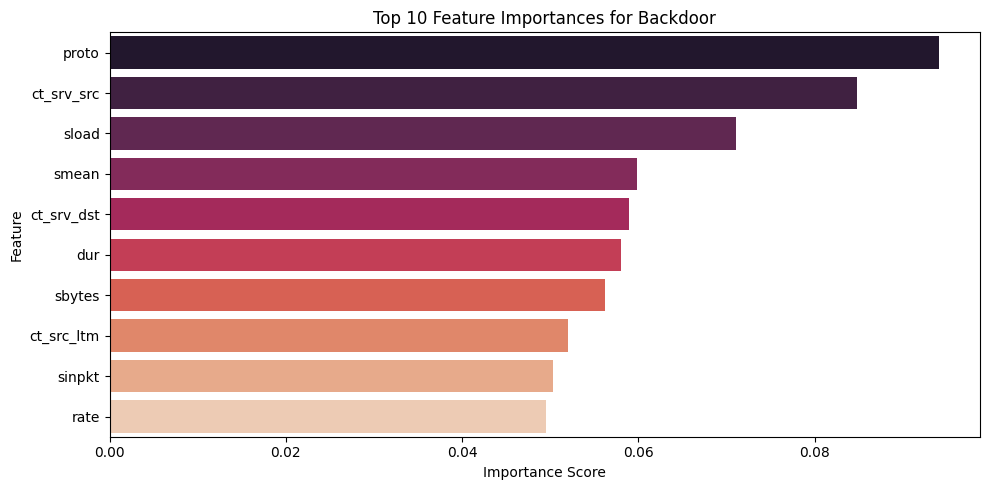


🔍 Generating feature importance for: Analysis (Label: Analysis)


<ipython-input-2-e061fc45b1bd>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')


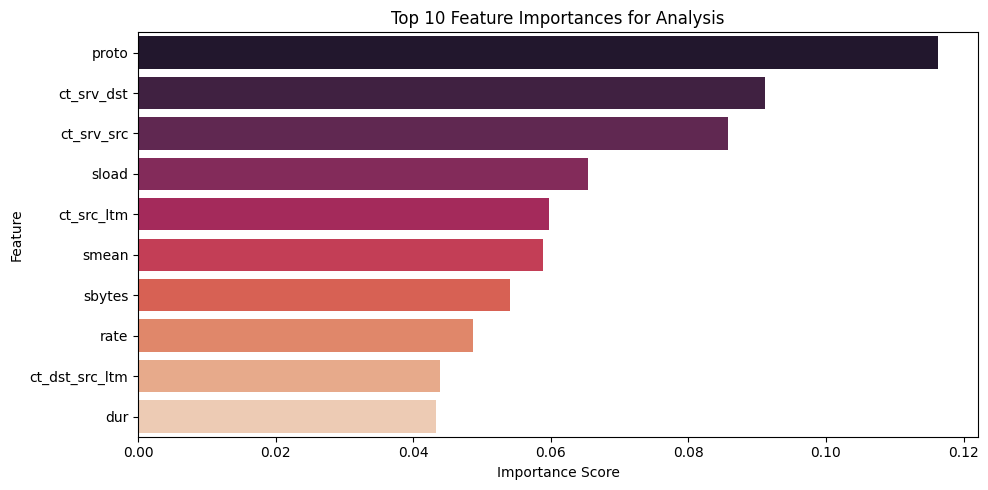

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Mount and load dataset
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/UNSW_NB15_training-set.csv'
df = pd.read_csv(data_path)

# Drop null values if any
df.dropna(inplace=True)

# Encode categorical features
categorical_cols = ['proto', 'service', 'state']
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Define your attack types of interest
attack_focus_list = [
    'Phishing', 'Malware', 'Man-in-the-middle (MitM)', 'DoS', 'SQL Injection',
    'Cross-site scripting (XSS)', 'Social Engineering', 'Zero-day Exploits',
    'Insider Threats', 'Eavesdropping', 'Wiretapping', 'Traffic Analysis',
    'Port Scanning', 'Packet Sniffing', 'Monitoring network traffic',
    'Backdoor', 'Analysis'
]

# Map these names to dataset attack_cat labels (edit as per your dataset's actual values)
# Please update the mapping to your dataset's attack_cat labels accordingly
attack_cat_mapping = {
    'Phishing': 'Shellcode',
    'Malware': 'Worms',
    'Man-in-the-middle (MitM)': 'Backdoor',
    'DoS': 'DoS',
    'SQL Injection': 'Exploits',
    'Cross-site scripting (XSS)': 'Fuzzers',
    'Social Engineering': 'Generic',
    'Zero-day Exploits': 'Shellcode',
    'Insider Threats': 'Backdoor',
    'Eavesdropping': 'Analysis',
    'Wiretapping': 'Analysis',
    'Traffic Analysis': 'Reconnaissance',
    'Port Scanning': 'Reconnaissance',
    'Packet Sniffing': 'Analysis',
    'Monitoring network traffic': 'Analysis',
    'Backdoor': 'Backdoor',
    'Analysis': 'Analysis'
}

# Select features (excluding attack_cat, label, etc.)
features = df.drop(columns=['id', 'attack_cat', 'label'])
feature_names = features.columns

# Loop through each attack, train model, and plot feature importances
for display_name, actual_label in attack_cat_mapping.items():
    print(f"\n🔍 Generating feature importance for: {display_name} (Label: {actual_label})")

    # Create binary label: 1 for this attack type, 0 for all others
    df['binary_target'] = df['attack_cat'].apply(lambda x: 1 if x == actual_label else 0)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(features, df['binary_target'], test_size=0.3, random_state=42)

    # Train Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10)  # Top 10

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket')
    plt.title(f"Top 10 Feature Importances for {display_name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


In [ ]:
!pip install shap scikit-learn --quiet


In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Example: Load UNSW NB15 training set
file_path = '/content/drive/MyDrive/Data/UNSW_NB15_training-set.csv'
df = pd.read_csv(file_path)

# Drop rows with missing values
df.dropna(inplace=True)

# Encode categorical features
categorical_cols = ['proto', 'service', 'state']
df = pd.get_dummies(df, columns=categorical_cols)

# Encode label
df['label'] = df['label'].astype(int)

# Drop unnecessary columns
df.drop(columns=['id', 'attack_cat'], inplace=True)

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
svm_model = LinearSVC(random_state=42, max_iter=10000)
svm_model.fit(X_train, y_train)

# Evaluation
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.91      0.91      7418
           1       0.92      0.92      0.92      9049

    accuracy                           0.91     16467
   macro avg       0.91      0.91      0.91     16467
weighted avg       0.91      0.91      0.91     16467



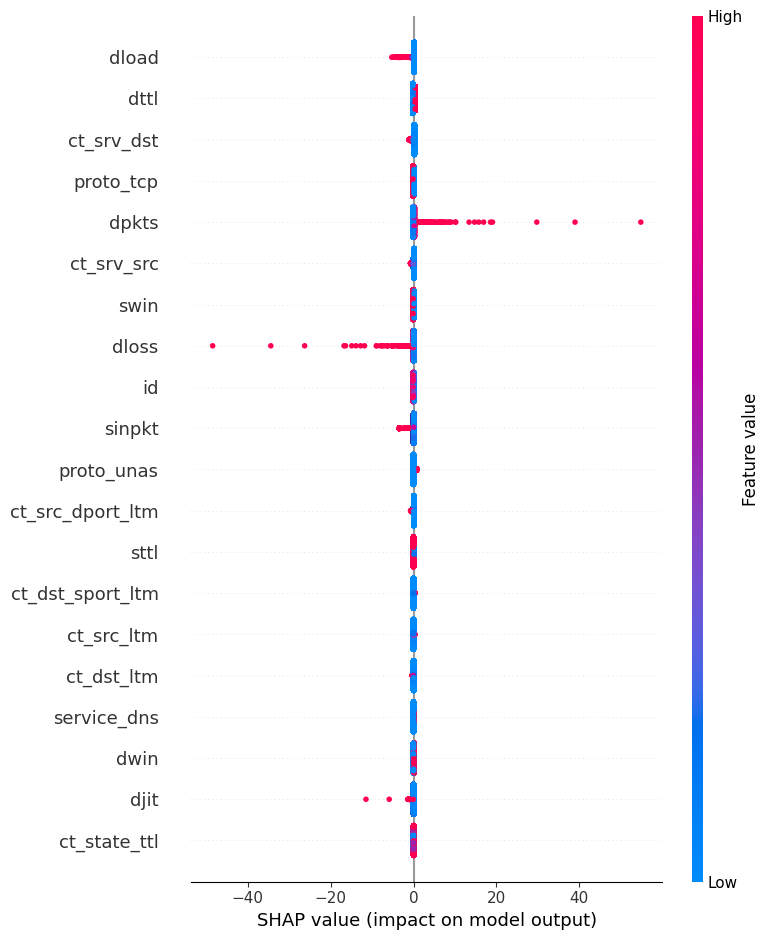

In [ ]:
# 🔧 SHAP-friendly Model Training & Explainer (Fixed version)

import shap
from sklearn.svm import LinearSVC

# Re-train with DataFrame instead of scaled NumPy arrays
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Scale again but preserve DataFrame structure
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X.columns)

# Train Linear SVM
svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train_scaled, y_train)

# ✅ Use SHAP with masker (new API)
masker = shap.maskers.Independent(X_train_scaled)
explainer = shap.Explainer(svm_model, masker)

# Calculate SHAP values
shap_values = explainer(X_test_scaled)

# 📊 Visualize summary of feature importance
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X_test_scaled.columns)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mt

/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


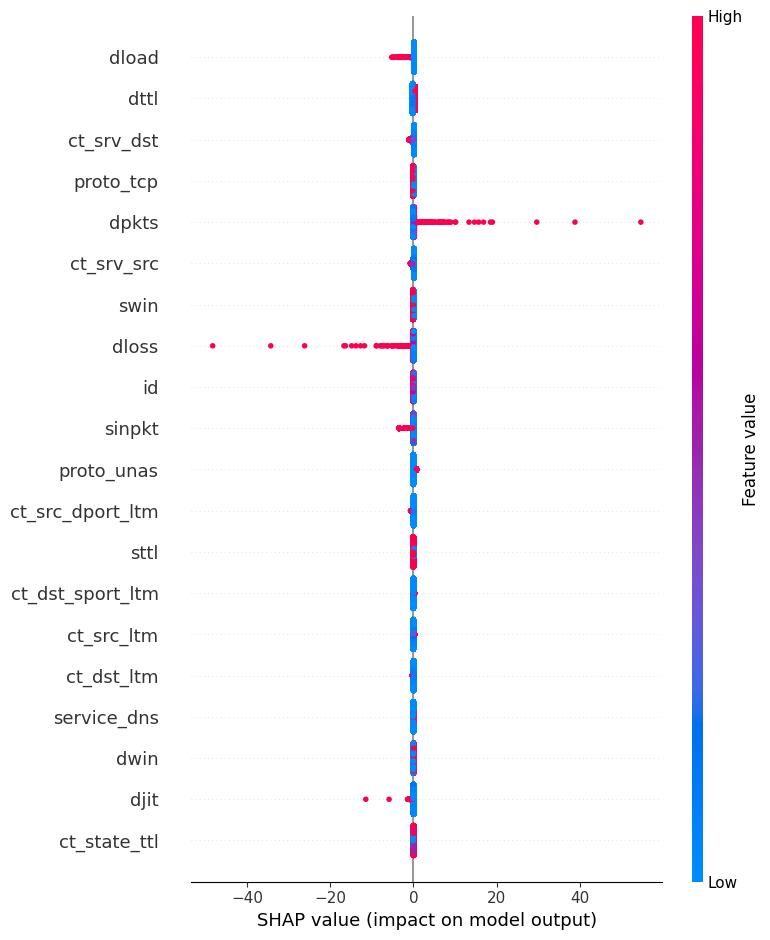

In [ ]:
# 📌 Install necessary packages
!pip install shap scikit-learn pandas matplotlib seaborn --quiet

# 📚 Import Libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from google.colab import drive

# 🔗 Mount Google Drive
drive.mount('/content/drive')

# 📂 Load the Dataset
file_path = '/content/drive/My Drive/Data/UNSW_NB15_training-set.csv'
df = pd.read_csv(file_path)

# 🔎 View dataset info (optional)
print(df.head())
print(df['attack_cat'].unique())

# 🎯 Select features and target
X = df.drop(['label', 'attack_cat'], axis=1)
y = df['attack_cat']

# Convert categorical features (if present)
X = pd.get_dummies(X)

# 🔍 Encode target to binary (Example: Binary Classification with 'DoS')
y_binary = y.apply(lambda x: 1 if x == 'DoS' else 0)

# 🧹 Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 📈 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.3, random_state=42)

# 🔧 Train Linear SVM (acts like LS-SVM in linear kernel form)
model = LinearSVC(max_iter=10000)
model.fit(X_train, y_train)

# 📊 Classification Report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 🔬 SHAP Explainer for Interpretability
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# 🧠 Visualize Feature Importance (Top impactful features)
feature_names = X.columns
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names)
